In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import shutil
from scipy.optimize import curve_fit
import math
import depletions_utils_alex as dep
import CogFunctions as cog
import spectro as spec
import spec_utils_alex  as specu
import os
import uncertainties as unc  
import uncertainties.unumpy as unumpy  
import uncertainties.umath as uncm

from astropy.convolution import convolve, Box1DKernel
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.ticker import MaxNLocator, MultipleLocator


/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import matplotlib
 
def set_rc_params(mult=1):
    matplotlib.rcParams.update({'font.size': 18*mult})
    #matplotlib.rc('font',family='serif')
    matplotlib.rcParams['legend.fontsize'] = 16*mult
    matplotlib.rcParams['axes.linewidth'] = 1.5
    matplotlib.rcParams['xtick.labelsize'] = 18*mult
    matplotlib.rcParams['ytick.labelsize'] = 18*mult
    matplotlib.rcParams['xtick.major.size'] = 10
    matplotlib.rcParams['ytick.major.size'] = 10
    matplotlib.rcParams['xtick.major.width'] = 2
    matplotlib.rcParams['ytick.major.width'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 5
    matplotlib.rcParams['ytick.minor.size'] = 5
    matplotlib.rcParams['xtick.minor.width'] = 1
    matplotlib.rcParams['ytick.minor.width'] = 1
    matplotlib.rcParams['xtick.direction'] = 'in'
    matplotlib.rcParams['ytick.direction'] = 'in'
    matplotlib.rcParams['xtick.bottom'] = True
    matplotlib.rcParams['ytick.left'] = True
    #matplotlib.rcParams['ytick.right'] = True
    matplotlib.rcParams["xtick.minor.visible"] = True
    matplotlib.rcParams["ytick.minor.visible"] = True
    matplotlib.rcParams['axes.labelsize'] = 25*mult
    matplotlib.rcParams['figure.figsize'] = (6,4)
set_rc_params(1)
 

In [3]:
# colors for plots
Cic, Cwlm, Csex = 'k', 'm', 'r'
Cmw, Clmc, Csmc = 'darkorange', 'deepskyblue', 'forestgreen'

## METAL-Z galaxies params

In [4]:
Z_IC1613, Z_SexA = 0.13, 0.08
HI = 1215.67
v_IC1613, v_SexA= -233, 324

In [5]:
# element abundances
Fe_sol, S_sol, O_sol, Mg_sol = -4.46, -4.74, -3.24, -4.38  # log(N(X)/N(H)) Asplund 2009

# log(Fe/H) = [Fe/H]+ log(Fe/H)_sol

# ic1613
# for log(S/H) we assume [S/H] = [O/H], so log(S/H) = log(O/H)-log(O/H)_sol + log(S/H)_sol + 

# [S/H] = [O/H]
# log(S/H) = log(O/H) - log(O/H)_sol + log(S/H)_sol (1)
# but
# log(O/H) = [O/H] + log(O/H)_sol
# therefore (1) shortens to
# log(S/H) = [O/H] + log(S/H)_sol

FeH_ic, OH_ic = -0.67, -0.79
FeH_sa, MgH_sa = -0.99, -1.09

logFeH_ic = FeH_ic + Fe_sol
logSH_ic = OH_ic + S_sol

print("IC1613", logFeH_ic, logSH_ic)

# SexA
logFeH_sa = FeH_sa + Fe_sol
logSH_sa = MgH_sa + S_sol

print("Sextans A", logFeH_sa, logSH_sa)

IC1613 -5.13 -5.53
Sextans A -5.45 -5.83


## Load the data tables

In [6]:
# spectra lines params
lines = np.loadtxt("line_list.txt", dtype='str')

# EW  measurement results
t = Table.read('metalZ-measurements.csv', format='csv')

# METAL-Z measurements (CoG)
metalz_cog = Table.read('METALZ-results.fits')
metalz = Table.read('METAL-Z_res_PF.fits')

# solar abundances for different elements in METAL
solar_ab = Table.read("reference_abundances.dat", format='ascii')

# Relation between elemental depletions from METAL: Fe and S
Mco = Table.read('metal-fe-s.txt', format='ascii')

# depletion coeffs for MW, relation with F*
depT = Table.read("dep_MW.txt", format='csv')

# MW correlations, d(X) - log NH
nhT = Table.read("dep-nh-MW.txt", format='csv')

In [7]:
solar_ab.show_in_notebook()

idx,Element,w,MW_A,MW_e1,MW_2,LMC_A,LMC_e1,LMC_e2,SMC_A,SMC_e1,SMC_e2
0,C,12.01,8.46,0.04,0.0,7.94,0.1,0.05,7.52,0.1,0.04
1,N,14.0,7.9,0.11,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,O,16.0,8.76,0.05,0.0,8.5,0.11,0.03,8.14,0.08,0.04
3,Mg,24.3,7.62,0.02,0.0,7.26,0.08,0.04,6.95,0.06,0.03
4,Si,28.1,7.61,0.02,0.0,7.35,0.1,0.02,6.86,0.07,0.09
5,P,30.97,5.54,0.04,0.0,5.1,0.0,0.0,4.7,0.0,0.0
6,Cr,52.0,5.72,0.05,0.0,5.37,0.07,0.03,4.99,0.1,0.05
7,Fe,55.85,7.54,0.03,0.0,7.32,0.08,0.03,6.85,0.08,0.03
8,Ni,58.7,6.29,0.03,0.0,5.92,0.07,0.03,5.57,0.18,0.07
9,Zn,65.4,4.7,0.04,0.0,4.31,0.15,0.15,3.91,0.2,0.14


In [8]:
metalz.show_in_notebook()

idx,sightline,RA [hex],Dec [hex],RA [deg],Dec [deg],log(N_SII),log(N_FeII),N(HI),d(Fe),d(S)
0,IC1613-61331,01:05:0.200,+02:09:13.10,16.2508,2.1536,15.354 .. 0.0,14.585 .. 0.0,20.84 .. 0.03,-1.12 .. 0.0,0.04 .. 0.0
1,IC1613-62024,01:05:0.6460,+02:08:49.26,16.2527,2.147,15.537 .. 0.0,14.836 .. 0.0,21.05 .. 0.03,-1.08 .. 0.0,0.02 .. 0.0
2,IC1613-64066,01:05.20700,+02:09:28.10,16.3017,2.1578,15.426 .. 0.0,14.798 .. 0.0,20.88 .. 0.04,-0.95 .. 0.0,0.08 .. 0.0
3,IC1613-67559,01:05:4.7670,+02:09:23.19,16.2699,2.1564,15.163 .. 0.0,14.61 .. 0.0,20.47 .. 0.14,-0.73 .. 0.0,0.22 .. 0.0
4,IC1613-67684,01:05:4.900,+02:09:32.60,16.2704,2.1591,14.974 .. 0.0,14.536 .. 0.0,20.44 .. 0.04,-0.77 .. 0.0,0.06 .. 0.0
5,IC1613-A13,01:05:6.25,+02:10:43.0,16.276,2.1786,15.114 .. 0.0,14.694 .. 0.0,20.26 .. 0.03,-0.44 .. 0.0,0.38 .. 0.0
6,IC1613-B11,01:04:43.8,+02:06:44.75,16.1825,2.1124,15.188 .. 0.0,14.411 .. 0.0,20.37 .. 0.05,-0.83 .. 0.0,0.35 .. 0.0
7,IC1613-B2,01:05:3.0680,+02:10:4.54,16.2628,2.1679,15.652 .. 0.0,14.988 .. 0.0,21.17 .. 0.03,-1.05 .. 0.0,0.01 .. 0.0
8,IC1613-B3,01:05:6.3700,+02:09:31.34,16.2765,2.1587,15.281 .. 0.0,14.486 .. 0.0,20.64 .. 0.06,-1.02 .. 0.0,0.17 .. 0.0
9,IC1613-B7,01:05:01.97,02:08:05.10,16.2582,2.1348,15.245 .. 0.0,14.707 .. 0.0,20.73 .. 0.03,-0.89 .. 0.0,0.04 .. 0.0


In [9]:
names = np.array([['SEXTANS-A-OB321', 'SEXTANS-A-s050'], ['SEXTANS-A-OB326', 'SEXTANS-A-s014'],
        ['SEXTANS-A-OB521', 'SEXTANS-A-s022'], ['SEXTANS-A-OB523', 'SEXTANS-A-s038'],
        ['SEXTANS-A-s3', 'SEXTANS-A-s029'], ['SEXTANS-A-SA1', 'SEXTANS-A-s037'],
         ['SEXTANS-A-SA2', 'SEXTANS-A-SA2 '], ['SEXTANS-A-SA3', 'SEXTANS-A-s021']])

## METAL

In [10]:
# depletions form METAL 

lmc = Table.read('../METAL_depletions_and_ci_results_with_env_fix1220.fits', format='fits')
smc = Table.read('../compiled_depletions_jenkins2017_py.fits', format='fits')
mw = Table.read('../compiled_depletions_jenkins2009_py_adj_zeropt_zn.fits', format='fits')

lmc_S, lmc_S_err, lmc_Fe, lmc_Fe_err = lmc['DEPLETIONS'][0:, 9],lmc['ERR_DEPLETIONS'][0:, 9], lmc['DEPLETIONS'][0:, 2], lmc['ERR_DEPLETIONS'][0:, 2]
smc_S, smc_S_err, smc_Fe, smc_Fe_err = smc['DEPLETIONS'][0:, 4],smc['ERR_DEPLETIONS'][0:, 4], smc['DEPLETIONS'][0:, 0], smc['ERR_DEPLETIONS'][0:, 0]
mw_S, mw_S_err, mw_Fe, mw_Fe_err = mw['DEPLETIONS'][0:, 14], mw['ERR_DEPLETIONS'][0:, 14], mw['DEPLETIONS'][0:, 5], mw['ERR_DEPLETIONS'][0:, 5]

lmc_NH, lmc_NH_err = lmc['LOG_NH'], lmc['ERR_LOG_NHI']
smc_NH, smc_NH_err = smc['LOG_NH'], smc['ERR_LOG_NHI']
mw_NH, mw_NH_err = mw['LOG_NH'], mw['ERR_LOG_NHI']

# Element abundances

In [11]:
mw_ab, lmc_ab, smc_ab = 0, 0, 0

for i in range(np.size(solar_ab)):
    
    mw_ab += 10**(solar_ab['MW_A'][i] - 12) * solar_ab['w'][i]
    lmc_ab += 10**(solar_ab['LMC_A'][i] - 12) * solar_ab['w'][i]
    smc_ab += 10**(solar_ab['SMC_A'][i] -12)  * solar_ab['w'][i]

In [12]:
# Fe abundances (ab - 12 )
mw_afe = solar_ab['MW_A'][7] - 12
lmc_afe = solar_ab['LMC_A'][7] - 12
smc_afe = solar_ab['SMC_A'][7] - 12

# METAL-Z DEPLETIONS

In [43]:
# scale abundaces of other elements
alpha = ['C', 'O', 'Mg', 'Si', 'S']
Fe_p = ['Ti', 'Cr', 'Fe', 'Ni', 'Cu', 'Zn']

print('alpha elements')
for a in alpha:
    k = np.where(solar_ab['Element'] == a)[0][0]
    wx = solar_ab['w'][k]
    sol = solar_ab['MW_A'][k]
    xab_ic = OH_ic + sol
    xab_sa = MgH_sa + sol

    print(f"{solar_ab['Element'][k]} & {wx:.2f} & {sol:.2f} & {xab_ic:.2f} & {xab_sa:.2f} \\\ ")


for a in Fe_p:
    
    k = np.where(solar_ab['Element'] == a)[0][0]
    wx = solar_ab['w'][k]
    sol = solar_ab['MW_A'][k]
    xab_ic = FeH_ic  + sol
    xab_sa = FeH_sa  + sol
    

    print(f"{solar_ab['Element'][k]} & {wx:.2f} & {sol:.2f} & {xab_ic:.2f} & {xab_sa:.2f} \\\ ")



alpha elements
C & 12.01 & 8.46 & 7.67 & 7.37 \\ 
O & 16.00 & 8.76 & 7.97 & 7.67 \\ 
Mg & 24.30 & 7.62 & 6.83 & 6.53 \\ 
Si & 28.10 & 7.61 & 6.82 & 6.52 \\ 
S & 32.06 & 7.26 & 6.47 & 6.17 \\ 
Ti & 47.87 & 5.00 & 4.33 & 4.01 \\ 
Cr & 52.00 & 5.72 & 5.05 & 4.73 \\ 
Fe & 55.85 & 7.54 & 6.87 & 6.55 \\ 
Ni & 58.70 & 6.29 & 5.62 & 5.30 \\ 
Cu & 63.55 & 4.34 & 3.67 & 3.35 \\ 
Zn & 65.40 & 4.70 & 4.03 & 3.71 \\ 


In [18]:
# calculate abundances of all elements for IC1613 and Sextans A assuming Fe elements behave te same, as are O,S

# scale abundaces of other elements
alpha = ['C', 'O', 'Mg', 'Si', 'S']
Fe_p = ['Ti', 'Cr', 'Fe', 'Ni', 'Cu', 'Zn']

print('alpha elements')
for a in alpha:
    k = np.where(solar_ab['Element'] == a)[0]
    j = np.where(depT['element'] == a)[0][0]
    
    sol = solar_ab['MW_A'][k][0] - 12
    xab_ic = OH_ic + sol
    xab_sex = MgH_sa + sol
    
    depT['ab_IC1613'][j] = xab_ic
    depT['ab_SextansA'][j] = xab_sex
    
    print(f"{a} & {sol:.2f} & {xab_ic:.2f} & {xab_sex:.2f} \\\ ")
    
print("\nFe peak")
for a in Fe_p:
    k = np.where(solar_ab['Element'] == a)[0]
    j = np.where(depT['element'] == a)[0][0]
        
    sol = solar_ab['MW_A'][k][0] - 12
    xab_ic = FeH_ic  + sol
    xab_sex = FeH_sa  + sol
    
    depT['ab_IC1613'][j] = xab_ic
    depT['ab_SextansA'][j] = xab_sex
    
    print(f"{a} & {sol:.2f} & {xab_ic:.2f} & {xab_sex:.2f} \\\ ")

# for plotting later, jst getting the abundances 
ab_ic_Si, ab_sa_Si = -5.18, -5.48
ab_ic_C, ab_sa_C = -4.33, -4.73

alpha elements
C & -3.54 & -4.33 & -4.63 \\ 
O & -3.24 & -4.03 & -4.33 \\ 
Mg & -4.38 & -5.17 & -5.47 \\ 
Si & -4.39 & -5.18 & -5.48 \\ 
S & -4.74 & -5.53 & -5.83 \\ 

Fe peak
Ti & -7.00 & -7.67 & -7.99 \\ 
Cr & -6.28 & -6.95 & -7.27 \\ 
Fe & -4.46 & -5.13 & -5.45 \\ 
Ni & -5.71 & -6.38 & -6.70 \\ 
Cu & -7.66 & -8.33 & -8.65 \\ 
Zn & -7.30 & -7.97 & -8.29 \\ 


In [14]:
depT.show_in_notebook()

idx,element,Ax,Axerr,Bx,Bxerr,zx,Wx,ab_IC1613,ab_SextansA
0,C,-0.1,0.23,-0.19,0.06,0.803,12.0107,-4.329999999999999,-4.629999999999999
1,O,-0.23,0.05,-0.14,0.05,0.598,15.999,-4.03,-4.33
2,Mg,-1.0,0.04,-0.8,0.02,0.531,24.305,-5.17,-5.47
3,Si,-1.14,0.06,-0.57,0.03,0.305,28.0855,-5.18,-5.4799999999999995
4,S,-0.879,0.28,-0.091,0.04,0.29,32.065,-5.53,-5.83
5,Ti,-2.05,0.06,-1.96,0.03,0.43,47.867,-7.67,-7.99
6,Cr,-1.45,0.06,-1.51,0.06,0.47,51.9961,-6.95,-7.2700000000000005
7,Fe,-1.28,0.04,-1.51,0.03,0.437,55.845,-5.13,-5.45
8,Ni,-1.49,0.06,-1.83,0.04,0.599,58.6934,-6.38,-6.7
9,Cu,-0.71,0.09,-1.1,0.06,0.711,63.546,-8.33,-8.65


In [15]:
# col dens and depletions table
for i in range(np.size(metalz['sightline'])):
        
        print(f"{metalz['sightline'][i]} & {metalz['N(HI)'][i][0]:.2f} $\pm$ {metalz['N(HI)'][i][1]:.2f}\
& {metalz['log(N_SII)'][i][0]:.2f}  $\pm$ {metalz['log(N_SII)'][i][1]:.2f} & {metalz['log(N_FeII)'][i][0]:.2f}\
$\pm$ {metalz['log(N_FeII)'][i][1]:.2f} & {metalz['d(S)'][i][0]:.2f} $\pm$ {metalz['d(S)'][i][1]:.2f} &\
{metalz['d(Fe)'][i][0]:.2f} $\pm$ {metalz['d(Fe)'][i][1]:.2f} \\\ ")


IC1613-61331 & 20.84 $\pm$ 0.03& 15.35  $\pm$ 0.05 & 14.59$\pm$ 0.06 & 0.04 $\pm$ 0.06 &-1.12 $\pm$ 0.07 \\ 
IC1613-62024 & 21.05 $\pm$ 0.03& 15.54  $\pm$ 0.07 & 14.84$\pm$ 0.07 & 0.02 $\pm$ 0.08 &-1.08 $\pm$ 0.08 \\ 
IC1613-64066 & 20.88 $\pm$ 0.04& 15.43  $\pm$ 0.06 & 14.80$\pm$ 0.07 & 0.08 $\pm$ 0.07 &-0.95 $\pm$ 0.08 \\ 
IC1613-67559 & 20.47 $\pm$ 0.14& 15.16  $\pm$ 0.07 & 14.61$\pm$ 0.06 & 0.22 $\pm$ 0.15 &-0.73 $\pm$ 0.15 \\ 
IC1613-67684 & 20.44 $\pm$ 0.04& 14.97  $\pm$ 0.07 & 14.54$\pm$ 0.07 & 0.06 $\pm$ 0.08 &-0.77 $\pm$ 0.08 \\ 
IC1613-A13 & 20.26 $\pm$ 0.03& 15.11  $\pm$ 0.08 & 14.69$\pm$ 0.09 & 0.38 $\pm$ 0.09 &-0.44 $\pm$ 0.09 \\ 
IC1613-B11 & 20.37 $\pm$ 0.05& 15.19  $\pm$ 0.07 & 14.41$\pm$ 0.08 & 0.35 $\pm$ 0.09 &-0.83 $\pm$ 0.09 \\ 
IC1613-B2 & 21.17 $\pm$ 0.03& 15.65  $\pm$ 0.07 & 14.99$\pm$ 0.06 & 0.01 $\pm$ 0.08 &-1.05 $\pm$ 0.07 \\ 
IC1613-B3 & 20.64 $\pm$ 0.06& 15.28  $\pm$ 0.08 & 14.49$\pm$ 0.08 & 0.17 $\pm$ 0.10 &-1.02 $\pm$ 0.10 \\ 
IC1613-B7 & 20.73 $\pm$ 0.03&

# METAL-Z: paper PLOTS and corresponding calculations

## Relation between d(Fe) and d(S)

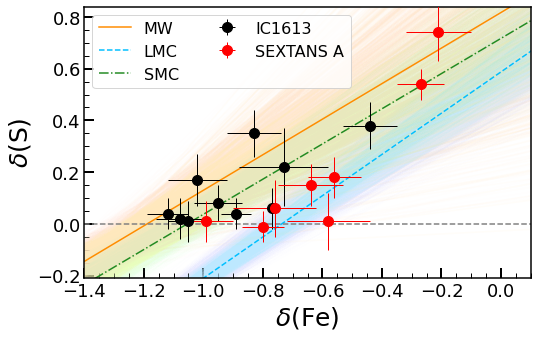

In [16]:
# Relation between d(Fe) and d(S)
# with Voigt
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)


ax1.set_xlabel(r'$\delta$(Fe)')
ax1.set_ylabel(r'$\delta$(S)', fontsize=25)
# ax1.set_ylim([-1.,1.5])
# ax1.set_xlim([-1.5,.25])

ax1.set_ylim([-.21, 0.84])
ax1.set_xlim([-1.4, 0.1])

dFe = np.linspace(-3,3, 100) #

## METAL depletion relations
#MW - 0 
k = 0
mw_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
mw_dS = dep.delta(mw_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
mw_t,mw_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)
# LMC
k = 1
lmc_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
lmc_dS = dep.delta(lmc_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
lmc_t,lmc_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)

# SMC
k = 2
smc_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
smc_dS = dep.delta(smc_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
smc_t,smc_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)

# propagate METAL relation errors
for i in range(1000):
    ax1.plot(dFe,mw_t.T[i], '-',c='#ffe8bd', alpha=np.sqrt(mw_p[i])/10.)
    ax1.plot(dFe,lmc_t.T[i], '-',c='#bde8ff', alpha=np.sqrt(lmc_p[i])/20.)
    ax1.plot(dFe,smc_t.T[i], '-',c='#e8ffbd', alpha=np.sqrt(smc_p[i])/30.)
    
# ## plot the METAL relations
ax1.plot(dFe, mw_dS, c=Cmw, ls='-' , label='MW')
ax1.plot(dFe, lmc_dS, c=Clmc, ls='--' , label='LMC')
ax1.plot(dFe, smc_dS, c=Csmc, ls='dashdot' , label='SMC')


#Voigt
ax1.errorbar(metalz['d(Fe)'][:10,0],metalz['d(S)'][:10,0], fmt='o', markeredgewidth=1,label='IC1613', markersize=10,
             markeredgecolor='k',markerfacecolor='k', xerr=metalz['d(Fe)'][:10,1], yerr=metalz['d(S)'][:10,1], ecolor='k', elinewidth=1, zorder=3000)
ax1.errorbar(metalz['d(Fe)'][10:,0],metalz['d(S)'][10:,0], fmt='o', markeredgewidth=1,label='SEXTANS A', markersize=10,
             markeredgecolor='r',markerfacecolor='r', xerr=metalz['d(Fe)'][10:,1], yerr=metalz['d(S)'][10:,1], ecolor='r', elinewidth=1, zorder=3000)


ax1.axhline(0, ls='--', color='gray')

ax1.legend(loc=2, ncol=2)

fig.savefig("dep-S-Fe.png", facecolor='white', bbox_inches='tight')



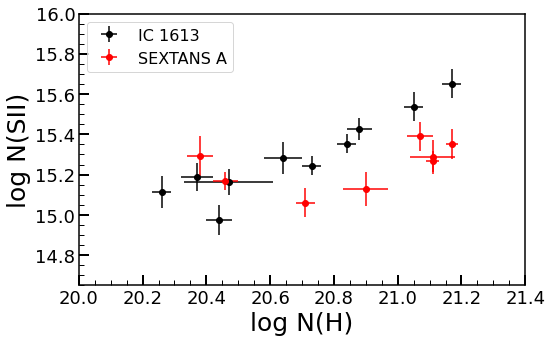

In [124]:
# N(SII) to N(HI)
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(111)


ax1.set_xlabel(r'log N(H)')
ax1.set_ylabel(r'log N(SII)', fontsize=25)
ax1.set_ylim([14.65, 16])
ax1.set_xlim([20, 21.4])

#plt.plot(metalz['N(HI)'][10:], new_voigt_s['mean'][10:], 'ro')
plt.errorbar(metalz['N(HI)'][:10].T[0], metalz['log(N_SII)'][:10].T[0], xerr = metalz['N(HI)'][:10].T[1], 
             yerr =  metalz['log(N_SII)'][:10].T[1], fmt='ko', label='IC 1613')
plt.errorbar(metalz['N(HI)'][10:].T[0], metalz['log(N_SII)'][10:].T[0], xerr = metalz['N(HI)'][10:].T[1],
             yerr = metalz['log(N_SII)'][10:].T[1], fmt='ro', label='SEXTANS A')

plt.legend(loc=2)

fig.savefig("nsii_nh.png", facecolor='white', bbox_inches='tight')

## Fe and S depletions with N(H) 

In [66]:
# From Bayesian fitting 
# parameter, lowr, upper limit (except for zH)
ic_abzH = np.array([[-0.54,0.18,0.19],[-0.91,0.04, 0.04], [20.74,0,0]])
sa_abzH = np.array([[-0.80, 0.20, 0.23], [-0.61, 0.06, 0.06], [20.86,0,0]])


In [72]:
#Fe depeltion at log N(H) = 21

dfe_ic = ic_abzH[0,0] * (21 - ic_abzH[2,0]) + ic_abzH[1,0]
dfe_sa = sa_abzH[0,0] * (21 - sa_abzH[2,0]) + sa_abzH[1,0]

#MW 
dfe_mw = -0.41 * (21 - 21.097) - 1.62

print(dfe_mw, dfe_ic, dfe_sa, abs(dfe_mw- dfe_ic),  abs(dfe_mw- dfe_sa) )

-1.5802299999999996 -1.0504000000000009 -0.7220000000000004 0.5298299999999987 0.8582299999999992


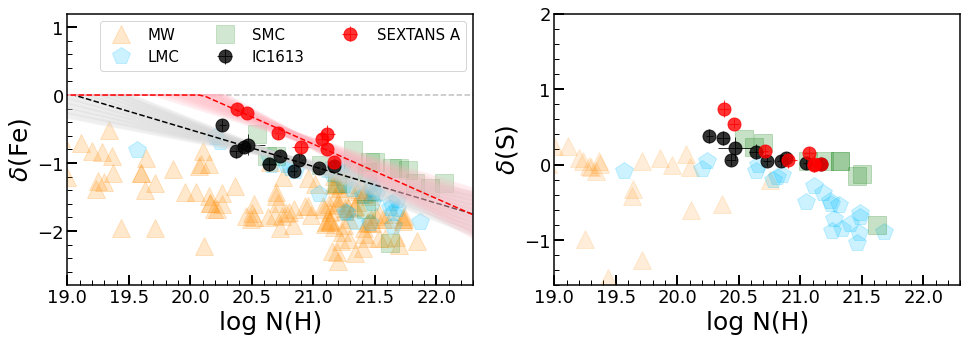

In [33]:
#compare to profile fit

# get dep(Fe) - logNH relations for METAL-Z
NH = np.linspace(18,23, 100)

fig = plt.figure(figsize=(16, 5))

plt.subplot(121)
plt.xlabel('log N(H)', fontsize=25)
plt.ylabel(r'$\delta$(Fe)', fontsize=25)
plt.xlim([19.,22.3])
plt.ylim([-2.8, 1.2])

plt.plot(mw_NH, mw_Fe, '^', label='MW', markersize=18, c=Cmw,alpha=0.2)
plt.plot(lmc_NH, lmc_Fe, 'p', label='LMC', markersize=18, c=Clmc,alpha=0.2)
plt.plot(smc_NH, smc_Fe, 's', label='SMC', markersize=18, c=Csmc,alpha=0.2)

# METAL-Z measurements
plt.errorbar(metalz['N(HI)'][:10,0],metalz['d(Fe)'][:10,0], fmt='o', markeredgewidth=1,label='IC1613', markersize=13,
             markeredgecolor='k',markerfacecolor='k', xerr=metalz['N(HI)'][:10,1], 
             yerr=metalz['d(Fe)'][:10,1], ecolor='k', elinewidth=1, alpha=0.8)
plt.errorbar(metalz['N(HI)'][10:, 0],metalz['d(Fe)'][10:,0], fmt='o', markeredgewidth=1,label='SEXTANS A', markersize=13,
             markeredgecolor='r',markerfacecolor='r', xerr=metalz['N(HI)'][10:,1], 
             yerr=metalz['d(Fe)'][10:,1], ecolor=Csex, elinewidth=1, alpha=0.8)

plt.legend(ncol=3, fontsize=15)
plt.axhline(0, ls='--', c='gray', alpha=0.5)

# FIT TO LINEAR RELATION

#### IC1613 Fe

# METAL-Z relations d(Fe) - log NH (fitted through bayes)
# If d(X) > 0, change to 0 (non physical)

aa_V = np.linspace(ic_abzH[0,0] - ic_abzH[0,1], ic_abzH[0,2] + ic_abzH[0,0], 10)
bb_V = np.linspace(ic_abzH[1,0] - ic_abzH[1,1], ic_abzH[1,2] + ic_abzH[1,0], 10)

Y = (NH - ic_abzH[2,0]) * ic_abzH[0,0] + ic_abzH[1,0]

for i in range(10):
    for j in range(10):
        
        y = (NH - ic_abzH[2,0]) * aa_V[i] + bb_V[j]
        plt.plot(NH,np.where(y < 0, y,0), '-', c='lightgrey', alpha=0.15)
        
plt.plot(NH, np.where(Y < 0, Y, 0), c='k', ls='--')
##### Sextans A Fe

aa_V = np.linspace(sa_abzH[0,0] - sa_abzH[0,1], sa_abzH[0,2] + sa_abzH[0,0], 10)
bb_V = np.linspace(sa_abzH[1,0] - sa_abzH[1,1], sa_abzH[1,2] + sa_abzH[1,0], 10)

Y = (NH - sa_abzH[2,0]) * sa_abzH[0,0] + sa_abzH[1,0]

for i in range(10):
    for j in range(10):
        
        y = (NH - sa_abzH[2,0]) * aa_V[i] + bb_V[j]
        plt.plot(NH,np.where(y < 0, y,0), '-', c='lightpink', alpha=0.15)
        
plt.plot(NH, np.where(Y < 0, Y, 0), c='r', ls='--')

plt.subplot(122)
plt.xlabel('log N(H)', fontsize=25)
plt.ylabel(r'$\delta$(S)', fontsize=25)
plt.xlim([19.,22.3])
plt.ylim([-1.6, 2])

# METAL measurements
plt.plot(mw_NH, mw_S, '^', label='MW', markersize=18, c=Cmw,alpha=0.15)
plt.plot(lmc_NH, lmc_S, 'p', label='LMC', markersize=18, c=Clmc,alpha=0.2)
plt.plot(smc_NH, smc_S, 's', label='SMC', markersize=18, c=Csmc,alpha=0.25)

# METAL-Z measurements
plt.errorbar(metalz['N(HI)'][:10,0],metalz['d(S)'][:10,0], fmt='o', markeredgewidth=1,label='IC1613', markersize=13,
             markeredgecolor='k',markerfacecolor='k', xerr=metalz['N(HI)'][:10,1], 
             yerr=metalz['d(S)'][:10,1], ecolor='k', elinewidth=1, alpha=0.8)
plt.errorbar(metalz['N(HI)'][10:,0],metalz['d(S)'][10:,0], fmt='o', markeredgewidth=1,label='SEXTANS A', markersize=13,
             markeredgecolor='r',markerfacecolor='r', xerr=metalz['N(HI)'][10:,1], 
             yerr=metalz['d(S)'][10:,1], ecolor=Csex, elinewidth=1, alpha=0.8)


fig.savefig("dep-S-Fe-NH-fit.png", facecolor='white',  bbox_inches='tight')



# D/G for METAL-Z

As we have only measurements of Fe nad S we need to make assuptions to include other elements in the D/G calculation. Based on the relations from METAL we assume that the relaiton between depletions for different elements, Vary minimally with metallicity. This assumption is more or less true depending on the element. We use MW relaitons, which has the most complete list of elements (including C and O) and scale the emasured relaitons for METAL-Z wwith the MW relaitons. Moreover, we have to assume the abundances of these other leements, dividing them into Fe-peak and alpha elements and scaling to the solar abundaces


1. Scale all other elements to Fe of IC1613/Sextans-A using MW coefficients to get d(X) - N(H) relations  <br>
2. Translate the d(X) - F* relations to d(X) - log NH (derive the dependances on log NH for different leements, based on the scaled relaitons) <br>
3. Caluculate the D/G and error (error by MC)

In [80]:
# MW depletion of Fe
a = np.where(depT['element'] == 'Fe')[0]
Afe, Bfe, zfe = depT['Ax'][a][0], depT['Bx'][a][0], depT['zx'][a][0]
print("Fe MW", Afe, Bfe, zfe)

NH = np.linspace(18, 23, 100)

Fe MW -1.28 -1.51 0.437


In [81]:
mw_mg = np.array([-0.26, 0.03, -0.83, 0.01, 21.121]) #AH, AHerr, BH, BHerr, zH
mw_si = np.array([-0.47, 0.05, -0.81, 0.03, 20.682])

In [82]:
def scale_DG(BHfe, BHfe_err, AHfe = -0.71, AHfe_err = 0.03, z0fe=21.288, gal='IC1613', plot=True):
    
    # Scale D(X) - d(Fe) relations to the galaxy Fe coefficients
    # (use MW coefficients for all elements, scale to the d(Fe) fitted to the data)
    # and form the d(X) relaitons with log NH  and calculate D/G vs NH
    # Derive the relations with log NH - elements scaled except for S which has measurement
    # and calculate the D/G
    

    dg, dg_err2, ab_sum = 0, 0, 0
    Afe, Bfe, zfe = -1.28, -1.51, 0.43
    NH = np.linspace(18, 23, 100)
    # relation d(Fe) from the fitted relation between d(Fe) and log NH
    dF = dep.dep_nh(NH, BHfe, AHfe) 

    # # Converting d(Fe) to F*
    Fs = dep.Fstar(dF,Afe,Bfe,zfe)
    
    # set up the coparison plot
    if plot == True:
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.xlabel('log N(H)', fontsize=25)
        plt.ylabel(r'$\delta$(Fe)', fontsize=25)
        plt.xlim([18.,22.5])
        plt.ylim([-3., 1.5]) 

    #scale Fe to other elemetns
    for i in range(np.size(depT['element'])):

        # include dF and dS as measured (and fitted)
        if depT['element'][i] == 'Fe' :

            dX_NH = dep.dep_nh(NH, BHfe, AHfe)
            dX_NH = np.where(dX_NH < 0, dX_NH, 0) # d(X) =  0 where d(X) > 0 from relation, flatten 

            # repeat the error propagation
            err_t, err_p = dep.mc_dep_fit_rel_errors(NH, 1, 0, 0, 0, 0, AHfe, AHfe_err, 
                                                     BHfe,BHfe_err, z0fe, nmc = 1000)
            err_std = np.std(err_t.T, axis=0)  # 1 sigma error
            
            if plot == True:
                ax.plot(NH, dX_NH, '--', label=depT['element'][i]) 

        # for other elements, scale the F* to nH relations

        else:    
            print(depT['element'][i], depT['Ax'][i], depT['Bx'][i], depT['zx'][i])
            dX_NH = depT['Ax'][i] * (Fs - depT['zx'][i]) + depT['Bx'][i]
            dX_NH = np.where(dX_NH < 0, dX_NH, 0)
            # propagate errors     
            err_t, err_p = dep.mc_dep_fit_rel_errors(Fs, Afe, 0, Bfe,0,zfe,depT['Ax'][i],depT['Axerr'][i],
                                                     depT['Bx'][i],depT['Bxerr'][i], depT['zx'][i], nmc = 1000)
            err_std = np.std(err_t.T, axis=0)
            
            if plot == True:
                ax.plot(NH, dX_NH, c='b' )

    # plot all relations and errors
    # plot the relation

        j = np.where(depT['element'][i] == nhT['element'])[0][0]
        #print(j, nhT['element'][j], depT['element'][i])
        mw = nhT['AH'][j] * (NH - nhT['zH0'][j]) + nhT['BH'][j] 

        ##calculate the D/G  adding the contirubution form each element. ! Must include the > 0 flattering
        
        galix = 'ab_'+gal
        
        dg += (1 - 10**(dX_NH))*depT['Wx'][i]* 10**(depT[galix][i])#4)
        dg_err2 +=(10**dX_NH*depT['Wx'][i]* 10**(depT[galix][i])*err_std)**2 #error propagation
        ab_sum += depT['Wx'][i]* 10**(depT[galix][i] ) # actual metallicity

    dg_nh =  dg /1.36   
    dg_err = np.sqrt(dg_err2 * np.log(10)/1.36)
    
    return (dg_nh, dg_err, ab_sum)

In [83]:
# fitted BH parameter for IC and Sextans A
BHfe_ic, BHfe_ic_err = ic_abzH[1,0], ic_abzH[1,1]
BHfe_sa, BHfe_sa_err = sa_abzH[1,0], sa_abzH[1,1]

AHfe_ic,AHfe_ic_err, zHfe_ic = ic_abzH[0,0], ic_abzH[0,2], ic_abzH[2,0]
AHfe_sa,AHfe_sa_err, zHfe_sa = sa_abzH[0,0], sa_abzH[0,2], sa_abzH[2,0]

In [84]:
dg_ICV = scale_DG(BHfe =BHfe_ic, BHfe_err = BHfe_ic_err, AHfe = AHfe_ic, AHfe_err = AHfe_ic_err, 
                  z0fe= zHfe_ic, gal='IC1613',plot=False)
dg_SAV = scale_DG(BHfe =BHfe_sa, BHfe_err = BHfe_sa_err, AHfe = AHfe_sa, AHfe_err = AHfe_sa_err,
                  z0fe=zHfe_sa, gal='SextansA', plot=False)

C -0.1 -0.19 0.803
O -0.23 -0.14 0.598
Mg -1.0 -0.8 0.531
Si -1.14 -0.57 0.305
S -0.879 -0.091 0.29
Ti -2.05 -1.96 0.43
Cr -1.45 -1.51 0.47
Ni -1.49 -1.83 0.599
Cu -0.71 -1.1 0.711
Zn -0.61 -0.38 0.555
C -0.1 -0.19 0.803
O -0.23 -0.14 0.598
Mg -1.0 -0.8 0.531
Si -1.14 -0.57 0.305
S -0.879 -0.091 0.29
Ti -2.05 -1.96 0.43
Cr -1.45 -1.51 0.47
Ni -1.49 -1.83 0.599
Cu -0.71 -1.1 0.711
Zn -0.61 -0.38 0.555


In [85]:
dm_ICV = dep.plot_dg_dm(NH, dg_ICV[0], dg_ICV[1], dg_ICV[2], title='IC1613', plot=False)
dm_SAV = dep.plot_dg_dm(NH, dg_SAV[0], dg_SAV[1], dg_SAV[2], title='SEXTANS A', plot=False)

### Comparison of D/G - NH for METAL and METAL-Z

In [106]:
def dg_dm_nh_fig(dg_IC,dm_IC, dg_SA, dm_SA, figname="dg_comp.png"):

    # comparison of D/G - NH
    
    fig = plt.figure(figsize=(7,10))
    plt.subplot(211)

    # read in the DG fro METAL galaxies

    lmc_dg = np.loadtxt('DG_vs_log_NH_LMC.dat', skiprows=1)
    smc_dg = np.loadtxt('DG_vs_log_NH_SMC.dat', skiprows=1)
    mw_dg = np.loadtxt('DG_vs_log_NH_MW.dat', skiprows=1)

    a = np.where(NH >= 19.5)
    ic, = plt.plot(NH[a], dg_IC[0][a], lw=3, c='k')
    sa, = plt.plot(NH[a], dg_SA[0][a], lw=3, c='r')
    l, = plt.plot(lmc_dg.T[0], lmc_dg.T[1], lw=2, c=Clmc)
    s, = plt.plot(smc_dg.T[0], smc_dg.T[1], lw=2, c=Csmc)
    m, = plt.plot(mw_dg.T[0], mw_dg.T[1], lw=2, c=Cmw)

    plt.fill_between(lmc_dg.T[0], lmc_dg.T[1] - lmc_dg.T[3], lmc_dg.T[1] + lmc_dg.T[3], color= Clmc, alpha=0.3)
    plt.fill_between(smc_dg.T[0], smc_dg.T[1] - smc_dg.T[3], smc_dg.T[1] + smc_dg.T[3], color= Csmc, alpha=0.3)
    plt.fill_between(mw_dg.T[0], mw_dg.T[1] - mw_dg.T[3], mw_dg.T[1] + mw_dg.T[3], color= Cmw, alpha=0.3)

    plt.fill_between(NH[a],dg_SA[0][a] - dg_SA[1][a], dg_SA[0][a]+dg_SA[1][a], color='r' , alpha=0.08)
    plt.fill_between(NH[a],dg_IC[0][a] - dg_IC[1][a], dg_IC[0][a]+dg_IC[1][a], color='k' , alpha=0.2)

    plt.xlim([19.3, 22])
    plt.ylim([1e-6, 5e-2])
    plt.yscale('log')

    plt.ylabel("D/G")

    plt.subplot(212)

    lmc_dm = lmc_dg.T[1] * 1.36 / lmc_ab
    smc_dm = smc_dg.T[1] * 1.36 / smc_ab
    mw_dm = mw_dg.T[1] * 1.36 / mw_ab

    lmc_dm_err = lmc_dg.T[3] * 1.36 / lmc_ab
    smc_dm_err = smc_dg.T[3] * 1.36 / smc_ab
    mw_dm_err = mw_dg.T[3] * 1.36 / mw_ab

    a = np.where(NH >= 19.5)
    ic, = plt.plot(NH[a], dm_IC[0][a], lw=3, c='k')
    sa, = plt.plot(NH[a], dm_SA[0][a], lw=3, c='r')
    l, = plt.plot(lmc_dg.T[0], lmc_dm, lw=2, c=Clmc)
    s, = plt.plot(smc_dg.T[0], smc_dm, lw=2, c=Csmc)
    m, = plt.plot(mw_dg.T[0], mw_dm, lw=2, c=Cmw)

    plt.fill_between(lmc_dg.T[0], lmc_dm - lmc_dm_err , lmc_dm + lmc_dm_err , color= Clmc, alpha=0.2)
    plt.fill_between(smc_dg.T[0], smc_dm - smc_dm_err, smc_dm  + smc_dm_err , color= Csmc, alpha=0.2)
    plt.fill_between(mw_dg.T[0], mw_dm - mw_dm_err, mw_dm + mw_dm_err, color= Cmw, alpha=0.2)

    plt.fill_between(NH[a],dm_SA[0][a] - dm_SA[1][a], dm_SA[0][a] + dm_SA[1][a], color='r' , alpha=0.1)
    plt.fill_between(NH[a],dm_IC[0][a] - dm_IC[1][a], dm_IC[0][a] + dm_IC[1][a], color='k' , alpha=0.1)

    plt.xlim([19.3, 22])
    plt.xlabel("log N(H)")
    plt.ylabel("D/M")
    plt.yscale('log')
    plt.legend([m,l,s,ic,sa], ["MW", "LMC","SMC", "IC1613", "SEXTANS A"], ncol=2)

    fig.savefig(figname,  bbox_inches='tight')


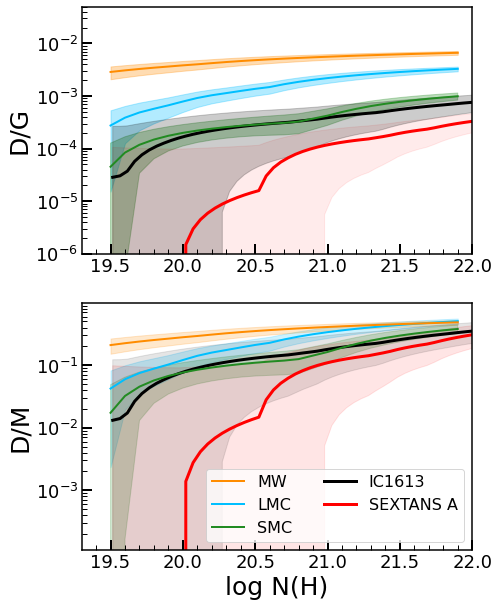

In [87]:
dg_dm_nh_fig(dg_ICV, dm_ICV, dg_SAV, dm_SAV, figname='dgdm_pf.png')

In [131]:
a   = np.where(abs(NH - 20.3) < 0.05)[0][0]
print(a)
print(dm_SAV[0][a])

mw_dg = np.loadtxt('DG_vs_log_NH_MW.dat', skiprows=1)
mw_dm = mw_dg.T[1] * 1.36 / mw_ab
b = np.where(abs(mw_dg.T[0] - 20.3)<0.05)[0][0]
print(b)
print(mw_dm[b])

print("at log N(H) = 20.3 D.G varies by ",mw_dm[b]/ dm_SAV[0][a], "between MW and SA")
c = np.where(abs(mw_dg.T[0] - 22)<0.05)[0]
print(mw_dm[-1])

45
0.008191269348502114
8
0.3237640320553167
at log N(H) = 20.3 D.G varies by  39.52550188262597 between MW and SA
0.48484950907070923


### Final D/G measurements with errors

In [62]:
# minimal N(H)
min_nhIC = np.min(metalz['N(HI)'][:10,0])
min_nhSA = np.min(metalz['N(HI)'][10:,0])

print(min_nhIC, min_nhSA)

20.26 20.38


In [64]:
## Final D/G measurements with errors
aIC = np.where(abs(NH-min_nhIC) <0.05)[0][0]
aSA = np.where(abs(NH-min_nhSA) <0.05)[0][0]
b = np.where(abs(NH-21) <0.05)[0][0]
c = np.where(abs(NH-22) <0.05)[0][0]

DG_ICnhV = np.zeros((3,2))
DG_SAnhV = np.zeros((3,2))

print("IC1613")
for k, n in zip([aIC,b,c], range(20,23)) :
    print(f"log N(H) = {n} D/G {dg_ICV[0][k] * 1e4:.2f} +/- {dg_ICV[1][k] * 1e4:.2f}, \
D/M  {dm_ICV[0][k]:.2f} +/- {dm_ICV[1][k]:.2f}")
    i = n - 20
    DG_ICnhV[i][0],DG_ICnhV[i][1] = dg_ICV[0][k], dg_ICV[1][k]
        
print("Sextans A")
for k, n in zip([aSA,b,c], range(20,23)) :
    print(f"log N(H) = {n} D/G {dg_SAV[0][k] * 1e4:.2f} +/- {dg_SAV[1][k] * 1e4:.2f}, \
D/M  {dm_SAV[0][k]:.2f} +/- {dm_SAV[1][k]:.2f}")
    i = n - 20
    DG_SAnhV[i][0], DG_SAnhV[i][1] = dg_SAV[0][k], dg_SAV[1][k]


IC1613
log N(H) = 20 D/G 2.26 +/- 2.23, D/M  0.10 +/- 0.10
log N(H) = 21 D/G 3.81 +/- 2.50, D/M  0.18 +/- 0.12
log N(H) = 22 D/G 7.56 +/- 2.69, D/M  0.35 +/- 0.12
Sextans A
log N(H) = 20 D/G 0.12 +/- 1.02, D/M  0.01 +/- 0.09
log N(H) = 21 D/G 1.15 +/- 1.14, D/M  0.11 +/- 0.11
log N(H) = 22 D/G 3.28 +/- 1.36, D/M  0.30 +/- 0.13


In [66]:
# DG Table
for k, n in zip([20,b,c], range(20,23)) :
    if k == 20:
        
        print(f"{n} cm$^{{-2}}$ & ({dg_ICV[0][aIC] * 1e4:.2f} +/- {dg_ICV[1][aIC] * 1e4:.2f})$\\times10^{{-4}}$ &\
{dm_ICV[0][aIC]:.2f} +/- {dm_ICV[1][aIC]:.2f} & ({dg_SAV[0][aSA] * 1e4:.2f} +/- {dg_SAV[1][aSA] * 1e4:.2f})$\\times10^{{-4}}$ & \
{dm_SAV[0][aSA]:.2f} +/- {dm_SAV[1][aSA]:.2f} \\\ ")
    
    else:
        print(f"{n} cm$^{{-2}}$ & ({dg_ICV[0][k] * 1e4:.2f} +/- {dg_ICV[1][k] * 1e4:.2f})$\\times10^{{-4}}$ &\
{dm_ICV[0][k]:.2f} +/- {dm_ICV[1][k]:.2f} & ({dg_SAV[0][k] * 1e4:.2f} +/- {dg_SAV[1][k] * 1e4:.2f})$\\times10^{{-4}}$ & \
{dm_SAV[0][k]:.2f} +/- {dm_SAV[1][k]:.2f} \\\ ")
    

20 cm$^{-2}$ & (2.26 +/- 2.23)$\times10^{-4}$ &0.10 +/- 0.10 & (0.12 +/- 1.02)$\times10^{-4}$ & 0.01 +/- 0.09 \\ 
21 cm$^{-2}$ & (3.81 +/- 2.50)$\times10^{-4}$ &0.18 +/- 0.12 & (1.15 +/- 1.14)$\times10^{-4}$ & 0.11 +/- 0.11 \\ 
22 cm$^{-2}$ & (7.56 +/- 2.69)$\times10^{-4}$ &0.35 +/- 0.12 & (3.28 +/- 1.36)$\times10^{-4}$ & 0.30 +/- 0.13 \\ 


## compare the obtained relations: Fe, S and Si & Mg for both galaxies


In [67]:
#IC1613 
dF_ic = dep.dep_nh(NH, b = BHfe_ic, a=AHfe_ic)
Fs_ic = dep.Fstar(dF_ic, Afe, Bfe, zfe)

si = np.where(depT['element'] == 'Si')[0]
mg = np.where(depT['element'] == 'Mg')[0]

dX_NH_ic_si = depT['Ax'][si] * (Fs_ic - depT['zx'][si]) + depT['Bx'][si]
dX_NH_ic_mg = depT['Ax'][mg] * (Fs_ic - depT['zx'][mg]) + depT['Bx'][mg]

dX_NH_ic_si = np.where(dX_NH_ic_si < 0, dX_NH_ic_si, 0)
dX_NH_ic_mg = np.where(dX_NH_ic_mg < 0, dX_NH_ic_mg, 0)

#Sextans A
dF_sa = dep.dep_nh(NH, b=BHfe_sa, a=AHfe_sa)
Fs_sa = dep.Fstar(dF_sa, Afe, Bfe, zfe)

si = np.where(depT['element'] == 'Si')[0]
mg = np.where(depT['element'] == 'Mg')[0]

dX_NH_sa_si = depT['Ax'][si] * (Fs_sa - depT['zx'][si]) + depT['Bx'][si]
dX_NH_sa_mg = depT['Ax'][mg] * (Fs_sa - depT['zx'][mg]) + depT['Bx'][mg]

dX_NH_sa_si = np.where(dX_NH_sa_si < 0, dX_NH_sa_si, 0)
dX_NH_sa_mg = np.where(dX_NH_sa_mg < 0, dX_NH_sa_mg, 0)


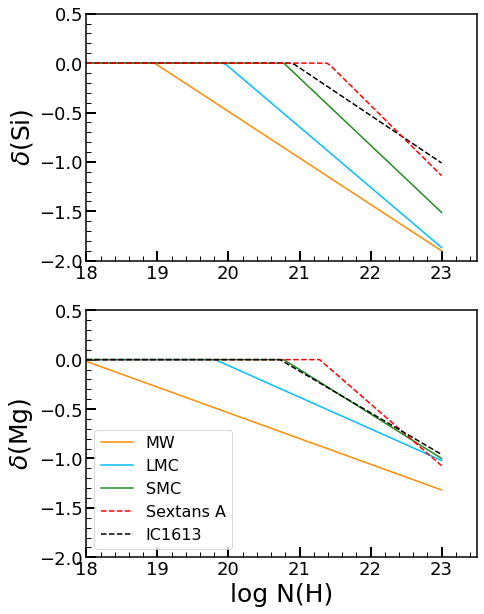

In [68]:
# depletion function with log NH for METAL
mw_mg = np.array([-0.26, 0.03, -0.83, 0.01, 21.121]) #AH, AHerr, BH, BHerr, zH
mw_si = np.array([-0.47, 0.05, -0.81, 0.03, 20.682])

lmc_mg = np.array([-0.32, 0.09, -0.5, 0.02, 21.374])
lmc_si = np.array([-0.61, 0.07, -0.67, 0.03, 21.04])

smc_mg = np.array([-0.45, 0.14, -0.32, 0.04, 21.490])
smc_si = np.array([-0.68, 0.08, -0.36, 0.03, 21.308])

fig = plt.figure(figsize=(7,10))

plt.subplot(211)

plt.plot(NH, dep.dep_logNH(NH,mw_si[0], mw_si[2], mw_si[4] ), c=Cmw, label='MW')
plt.plot(NH, dep.dep_logNH(NH,lmc_si[0], lmc_si[2], lmc_si[4] ), c=Clmc, label='LMC')
plt.plot(NH, dep.dep_logNH(NH,smc_si[0], smc_si[2], smc_si[4] ), c=Csmc, label='SMC')
plt.plot(NH, dX_NH_ic_si, '--', label="IC1613", c='k')
plt.plot(NH, dX_NH_sa_si, '--', label="Sextans A", c='r')


#plt.xlabel('log N(H)', fontsize=24)
plt.ylabel(r'$\delta$(Si)')
plt.xlim([18.,23.5])
plt.ylim([-2.0, 0.5]) 

plt.subplot(212)

plt.plot(NH, dep.dep_logNH(NH,mw_mg[0], mw_mg[2], mw_mg[4] ), c=Cmw, label='MW')
plt.plot(NH, dep.dep_logNH(NH,lmc_mg[0], lmc_mg[2], lmc_mg[4] ), c=Clmc, label='LMC')
plt.plot(NH, dep.dep_logNH(NH,smc_mg[0], smc_mg[2], smc_mg[4] ), c=Csmc, label='SMC')
plt.plot(NH, dX_NH_sa_mg, '--', label="Sextans A", c='r')
plt.plot(NH, dX_NH_ic_mg, '--', label="IC1613", c='k')


plt.xlabel('log N(H)')
plt.ylabel(r'$\delta$(Mg)')
plt.xlim([18.,23.5])
plt.ylim([-2.0, 0.5]) 
plt.legend()
fig.savefig("si_mg_dep.png",  bbox_inches='tight')

## D/G vs metallicity, comparison to METAL, FIR, models and DLAs

Checking for the tesion. FIR measurements for log NH < 21 (when known only) to see if they match teh METAL-Z galaxies

In [75]:
from astropy.io import ascii, fits

def feldmann2015_model(gamma = 10.**(np.arange(3, 6.1, 0.5)) ):

    ng = len(gamma) #7
    nz = 50

    z = 10.**(np.linspace(-3, 0.5, nz))*0.014

    R = 0.46
    epsilon_out = 2.
    y = 6.9e-2
    y_D= 6.9e-4
    r_Z = 0.25
    r_D = 0.
    f_dep = 0.7
    epsilon_SN  = 10.
    #r = 1./(1.-R + epsilon_out)
    #print("CHECK ", r, R)
    r = z*(1.-r_Z)/y/(1.-R)


    alpha = y_D*(1.-R)

    dog = np.zeros([nz, ng])

    dm = y_D/y*(1.-r_Z)/(1.-r_D)*z
    dp = f_dep*z

    for ig in range(len(gamma)):

        beta = gamma[ig]*f_dep*z[:]-(epsilon_SN + R + (1.-r_D)/r)
        dog[:, ig] = beta[:]/(2.*gamma[ig]) + ( (beta/(2.*gamma[ig]))**2 + alpha/gamma[ig])**(0.5)


    return(z, gamma, dog, dm , dp, alpha)

def plot_feldmann_tenure_metalz(log_nh0_mw = 21., use_fe_dla=False, use_gal_dla = 'dla'):

    ### read D/G for METAL galaxies
    dg_metal = Table.read("metal-dg.txt", format='csv')

    ##HERE total_dust_mass; total_dust_mass_error; total_gas_mass; total_gas_mass_error;

    zs = np.array([1., 0.5, 0.2, 0.15, 0.08])
    gals = np.array(['MW', 'LMC', 'SMC', 'IC1613', 'Sextans-A'])
    c1, c2 ='#fde725', '#440154'
    
    gal_cols = [c1,c1,c1, Cic, Csex]

    z0min, gamma0min, dog0min, dm0min, dp0min, alpha0min = feldmann2015_model(gamma = [2e4] )
    z0min = z0min/0.014
    z0max, gamma0max, dog0max, dm0max, dp0max, alpha0max = feldmann2015_model(gamma = [4e4] )
    z0max = z0max/0.014

    zmin, gammamin, dogmin, dmmin, dpmin, alphamin = feldmann2015_model(gamma = [2e3] )
    zmin = zmin/0.014

    zmax, gammamax, dogmax, dmmax, dpmax, alphamax = feldmann2015_model(gamma = [1e6] )
    zmax = zmax/0.014

    z0, gamma0, dog0, dm0, dp0, alpha0 = feldmann2015_model(gamma = [3e4] )
    z0 = z0/0.014

    dla = ascii.read('decia2016_table6.dat')
    devis = ascii.read('dustpedia_combined_sample.csv')
    remy_ruyer = ascii.read('remy-ruyer2014_dust_gas_masses.dat')

    plt.clf()
    plt.close()

    fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (9,9))
    #plt.grid()
    ax.fill_between(zmin, dogmin[:,0],dog0min[:,0], color = 'silver', alpha = 0.65)
    ax.fill_between(zmax, dog0max[:,0],dogmax[:,0], color = 'silver', alpha = 0.65)
    ax.plot(z0, dog0, '--', color='grey')

    dumz = np.arange(5e-3, 3, 0.001)
    ind = np.where(z0 == 1)
    ind = ind[0]
    dumdg = dog0.flatten()[ind]*dumz

    ax.plot(dumz, dumdg, '-', linewidth=3, color='grey')
    ax.text(6e-3, 8.e-5, 'D/G '  +u"\u221D" + ' Z', color = 'black', fontsize = 15, rotation = 18)
    ax.text(0.2, 8e-6, 'Model Tracks', fontsize = 13, color = 'gray')
    ax.text(0.2, 5e-6, '(Feldmann+2015)', fontsize = 13, color = 'gray')

    #  DE VIS

    ax.plot(devis['Z'].data, devis['Mdust'].data/devis['Mgas'].data, 'o',  markerfacecolor = '#3b528b',
            markeredgecolor='none', label = 'FIR (Remy-Ruyer+2014, De Vis+2019)', alpha = 0.6)
    ax.plot(10.**(remy_ruyer['12+log(O/H)'].data-8.76), remy_ruyer['Mdust'].data/remy_ruyer['Mgas'].data, 'o', 
            markerfacecolor = '#3b528b',  markeredgecolor='none', alpha = 0.6)

    #  DLAs - need to scale to log_nh0_mw

    if use_fe_dla==True:
        key='_Fe'
    else:
        key=''
    tfit = ascii.read("LMC_fit_DG_NH.dat")
    fslope = tfit['slope'].data[0]
    foffset= tfit['offset'].data[0]
    err_fslope = tfit['err_slope'].data[0]
    err_foffset= tfit['err_offset'].data[0]
    dla = fits.open("DeCia2016_all_data_"+use_gal_dla + key + ".fits")
    dla = dla[1].data

    scaled_dg  = dla['DTG'] + fslope*(log_nh0_mw-dla['LOG_NHI'])
    err_scaled_dg = np.sqrt(dla['err_DTG']**2 + (fslope*(log_nh0_mw-dla['LOG_NHI']))**2*((err_fslope/fslope)**2 + 
                           (dla['ERR_LOG_NHI']/dla['LOG_NHI'])**2))

    good_dla = np.where((dla['LOG_NHI']>=19.5) & (dla['DTG'] >0))
    ax.plot(dla['tot_A_Fe'][good_dla]/10.**(7.54-12.), dla['DTG'][good_dla], 'o', markerfacecolor = 'magenta', 
            markeredgecolor='none', label = 'DLAs (Quiret+2016, DeCia+2016)' , alpha = 0.5)

    dla = fits.open("Quiret2016_DTG_table_"+use_gal_dla + key + ".fits")
    dla = dla[1].data
    scaled_dg  = dla['DTG'] + fslope*(log_nh0_mw-dla['LOG_NHI'])
    err_scaled_dg = np.sqrt(dla['err_DTG']**2 + (fslope*(log_nh0_mw-dla['LOG_NHI']))**2*((err_fslope/fslope)**2 +
                                    (dla['ERR_LOG_NHI']/dla['LOG_NHI'])**2))
    good_dla = np.where((dla['LOG_NHI']>=19.5) & (dla['DTG'] >0))
    ax.plot(dla['tot_A_Fe'][good_dla]/10.**(7.54-12.), dla['DTG'][good_dla], 'o',  markerfacecolor = 'magenta' , 
            markeredgecolor='none', alpha = 0.5)
    
    chris = np.array([3.5e-3, 1.5e-4])/ 1.36
    plt.plot([zs[1]- 0.05, zs[2]-0.01], chris, '*', ms=25, markerfacecolor=Clmc,markeredgewidth=1,markeredgecolor='k',
             label=r'FIR at log N(H) = 21 cm$^{-2}$ LMC/SMC  (Clark+2023)')

    shi = 7.142e-5
    plt.plot([zs[-1]], shi, '*', ms=25, markerfacecolor='lightgreen',markeredgewidth=1,markeredgecolor='k',
             label=r'Integrated FIR Sextans A (Shi+2014)')
    for i in range(3): #METAL depletion measures

        linewidth = 4
        if gals[i] == 'MW':
            ax.plot(zs[i],dg_metal['dg_N20'][i],'o', markerfacecolor = '#fde725', 
                    label = "MW/LMC/SMC (Roman-Duval+2022a)", markersize = 17, alpha= 0.8, markeredgecolor='k', 
                    markeredgewidth=2)
         
        ax.plot(zs[i]-0.01,dg_metal['dg_N20'][i],'o',color = gal_cols[i], markersize = 17, alpha= 0.8, 
                markeredgecolor='k', markeredgewidth=2)
        ax.plot(zs[i],dg_metal['dg_N21'][i],'s', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k',
         markeredgewidth=2)
        ax.plot(zs[i],dg_metal['dg_N22'][i],'^', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k', 
         markeredgewidth=2)
    

     # METAL-Z    
    ax.plot(-1,-1,'o', markerfacecolor = 'k', label = "IC1613 (this work)", 
            markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
    ax.plot(-1,-1,'o', markerfacecolor = 'r', label = "Sextans A (this work)", 
            markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
    

    for j in range(3):
        
        if j == 0: 
            dx = 0.01
            f = 'o'
        elif j == 1:
            dx = 0
            f = 's'
        elif j == 2: 
            dx = 0
            f = '^'

        #profile fit

#         if j == 0:
#             ax.errorbar(zs[4] - dx-0.02, DG_SAnhV[j][0] ,yerr= DG_SAnhV[j][1], fmt=f, markerfacecolor = 'r', 
#                  markersize = 17, markeredgecolor='k', markeredgewidth=2, color='r', uplims=True, lw=2)
#             ax.errorbar(zs[3] - dx-0.04, DG_ICnhV[j][0], yerr=DG_ICnhV[j][1] , fmt=f, markerfacecolor = 'k', 
#                  markersize = 17, markeredgecolor='k',  markeredgewidth=2, color='k', uplims=True, lw=2)
#         else:
        ax.errorbar(zs[4] - dx-0.02, DG_SAnhV[j][0],yerr=DG_SAnhV[j][1], fmt=f, markerfacecolor = 'r', 
             markersize = 17, markeredgecolor='k', markeredgewidth=2, color='r')
        ax.errorbar(zs[3] - dx-0.02, DG_ICnhV[j][0],yerr=DG_ICnhV[j][1], fmt=f, markerfacecolor = 'k', 
             markersize = 17, markeredgecolor='k',  markeredgewidth=2, color='k')
    #ax.errorbar(zs[4] - dx-0.02, DG_SAnhV[j][0],yerr=DG_SAnhV[j][1], fmt=f, markerfacecolor = 'r', 
    #             markersize = 17, markeredgecolor='k', markeredgewidth=2, color='r')

    o, = ax.plot(-1,1,'o', color = gal_cols[i], markersize = 17, alpha= 0.8, markeredgecolor='k', 
                 markerfacecolor='none',  markeredgewidth=2)
    s, = ax.plot(-1,1,'s', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k',  
                 markerfacecolor='none', markeredgewidth=2)
    d, = ax.plot(-1,1,'^', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k',  
                 markerfacecolor='none', markeredgewidth=2)
   
    ncol=[] 
    ncol.append([o,s,d])
    leg1 = ax.legend(ncol[0], ['log N(H) = 20 cm$^{-2}$','log N(H) = 21 cm$^{-2}$','log N(H) = 22 cm$^{-2}$'], 
                    fontsize=12, loc=4)
    leg1.legendHandles[0].set_color('k')
    
    ax.set_xlim(left = 5.e-3,right=3.)
    ax.set_ylim(bottom = 3.e-7, top = 0.5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Z [" + r'$Z_o$' + "]")
    ax.set_ylabel('D/G')
    
    #ax.annotate("Typical\nerrorbar", (1.2, 3e-5), fontsize=12, c='gray')

    first_legend = plt.legend(handles=[o,s,d], loc='upper right', ncol=2)

    # Add the legend manually to the current Axes.
    ax.legend(fontsize = 12, loc = 'upper left')
    plt.gca().add_artist(leg1)


    fig.savefig("plot_feldmann2015_metalz.pdf", dpi=1000, bbox_inches='tight', facecolor='white')


<ipython-input-75-361e409c612c>:194: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg1.legendHandles[0].set_color('k')
<ipython-input-75-361e409c612c>:206: UserWarning: The label '_child37' of <matplotlib.lines.Line2D object at 0x7faad14c2cd0> starts with '_'. It is thus excluded from the legend.
  first_legend = plt.legend(handles=[o,s,d], loc='upper right', ncol=2)
<ipython-input-75-361e409c612c>:206: UserWarning: The label '_child38' of <matplotlib.lines.Line2D object at 0x7faad14c2a00> starts with '_'. It is thus excluded from the legend.
  first_legend = plt.legend(handles=[o,s,d], loc='upper right', ncol=2)
<ipython-input-75-361e409c612c>:206: UserWarning: The label '_child39' of <matplotlib.lines.Line2D object at 0x7faad108dc40> starts with '_'. It is thus excluded from the legend.
  first_legend = plt.legend(handles=[o,s,d], loc='upper right', ncol=2)


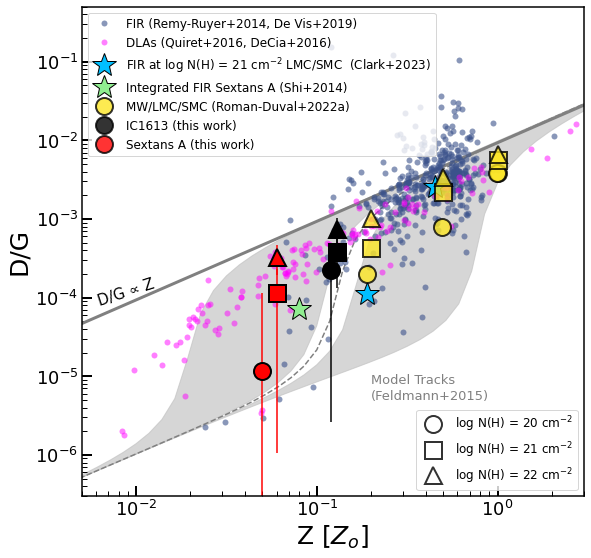

In [76]:
plot_feldmann_tenure_metalz()

In [49]:
# checking the numbers for the text
# diference betweec Clark+23 FIR and SMC at 21 cm

dg_metal = Table.read("metal-dg.txt", format='csv')
chris = np.array([3.5e-3, 1.5e-4])/ 1.36
dg_metal['dg_N21'][2]/chris[1]


3.8442666666666674

In [50]:
c = 1.5e-4 / 1.36
d = 4.24e-4
d/c


3.8442666666666674

## D_Fe / G - only measurements

In [51]:
## Mass of Fe, using D/G equation, only for Fe
# dg += (1 - 10**(dX_NH))*depT['Wx'][i]* 10**(depT['ab_IC1613'][i])#4)

In [44]:
def dFe_logDFe(dfe, dfe_err, ab,  Wx = 55.845 ):
    
    logmfe = np.zeros((np.size(dfe),2))
    mfe = np.zeros((np.size(dfe),2))
    dgfe = np.zeros((np.size(dfe),2))
    
    for j in range(np.size(dfe)):
        # M(Fe) and err
        x = unc.ufloat(dfe[j],dfe_err[j])
        dg = 1 / 1.36 * (1 - 10 ** x)* Wx * 10 ** (ab)
        dg_err = dg.s
        log_dg = uncm.log10(dg) 
        
        mfe[j] = np.array([dg.nominal_value, dg.s])
        logmfe[j] = np.array([log_dg.nominal_value, log_dg.s])
        df = 1 - 10 ** x
        dgfe[j] = np.array([df.nominal_value, df.s])
        
    return dgfe, logmfe

In [45]:
# Fe D_Fe / G for METAL
dgfe_mw, logmfe_mw = dFe_logDFe(mw_Fe, mw_Fe_err, ab = Fe_sol)
dgfe_lmc, logmfe_lmc = dFe_logDFe(lmc_Fe, lmc_Fe_err, ab = lmc_afe)
dgfe_smc, logmfe_smc = dFe_logDFe(smc_Fe, smc_Fe_err, ab = smc_afe)

/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)
/Users/ahamanowicz/opt/anaconda3/envs/astro/lib/python3.8/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)


In [46]:
#Fe D_FE / G for METAL-Z
I = np.where(depT['element'] == 'Fe')[0][0]

dgfe_icV, logmfe_icV = dFe_logDFe(metalz['d(Fe)'][:10,0], metalz['d(Fe)'][:10,1], ab = depT['ab_IC1613'][I])
dgfe_saV, logmfe_saV = dFe_logDFe(metalz['d(Fe)'][10:,0], metalz['d(Fe)'][10:,1], ab = depT['ab_SextansA'][I])

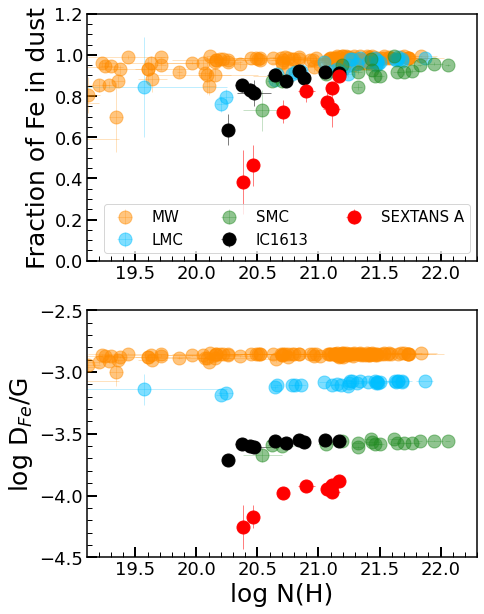

In [47]:
fig = plt.figure(figsize=(7,10))
plt.subplot(211)
plt.errorbar(mw_NH, dgfe_mw.T[0], xerr=mw_NH_err,
            yerr=dgfe_mw.T[1], fmt= 'o',markerfacecolor=Cmw, markeredgecolor=Cmw,ecolor=Cmw, 
             elinewidth=0.5, ms=13, alpha=0.5, label='MW')
plt.errorbar(lmc_NH, dgfe_lmc.T[0], xerr=lmc_NH_err,
            yerr=dgfe_lmc.T[1], fmt= 'o',markerfacecolor=Clmc, 
             markeredgecolor=Clmc,ecolor=Clmc, elinewidth=0.5, ms=13, alpha=0.5, label='LMC')
plt.errorbar(smc_NH, dgfe_smc.T[0], xerr=smc_NH_err,
            yerr=dgfe_smc.T[1], fmt= 'o',markerfacecolor=Csmc, 
             markeredgecolor=Csmc,ecolor=Csmc, elinewidth=0.5, ms=13, alpha=0.5, label='SMC')


plt.errorbar(metalz['N(HI)'][:10,0], dgfe_icV.T[0], xerr=metalz['N(HI)'][:10,1],
              yerr=dgfe_icV.T[1], fmt= 'ko', elinewidth=0.5, ms=13, label='IC1613')

plt.errorbar(metalz['N(HI)'][10:,0], dgfe_saV.T[0], xerr=metalz['N(HI)'][10:,1], 
              yerr=dgfe_saV.T[1], fmt= 'ro', elinewidth=0.5, ms=13, label='SEXTANS A')
plt.legend(loc=4, fontsize=15, ncol=3)
plt.xlim([19.1, 22.3])
plt.ylim([0, 1.2])
plt.ylabel("Fraction of Fe in dust")

plt.subplot(212)
plt.errorbar(mw_NH, logmfe_mw.T[0], xerr=mw_NH_err, yerr=logmfe_mw.T[1], fmt= 'o',markerfacecolor=Cmw, markeredgecolor=Cmw,ecolor=Cmw, 
             elinewidth=0.5, ms=13, alpha=0.5, label='MW')
plt.errorbar(lmc_NH, logmfe_lmc.T[0], xerr=lmc_NH_err,
            yerr=logmfe_lmc.T[1], fmt= 'o',markerfacecolor=Clmc, 
             markeredgecolor=Clmc,ecolor=Clmc, elinewidth=0.5, ms=13, alpha=0.5, label='LMC')
plt.errorbar(smc_NH, logmfe_smc.T[0], xerr=smc_NH_err,
            yerr=logmfe_smc.T[1], fmt= 'o',markerfacecolor=Csmc, 
             markeredgecolor=Csmc,ecolor=Csmc, elinewidth=0.5, ms=13, alpha=0.5, label='SMC')

plt.errorbar(metalz['N(HI)'][:10,0], logmfe_icV.T[0], xerr=metalz['N(HI)'][:10,1],
             yerr=logmfe_icV.T[1], fmt= 'ko', elinewidth=0.5, ms=13, label='IC1613')

plt.errorbar(metalz['N(HI)'][10:,0], logmfe_saV.T[0], xerr=metalz['N(HI)'][10:,1], 
             yerr=logmfe_saV.T[1], fmt= 'ro', elinewidth=0.5, ms=13, label='SEXTANS A')

plt.xlim([19.1, 22.3])
plt.ylim([-4.5, -2.5])
plt.ylabel(r"log D$_{Fe}$/G")
plt.xlabel(r"log N(H)")

fig.savefig("MFE_Nh.png", facecolor='white',  bbox_inches='tight')


In [61]:
# franction of Fe in dust at log N(H ) = 21
#ic
a=np.where((metalz['N(HI)'][:10,0] < 21.2) & (metalz['N(HI)'][:10,0] > 20.8))[0]
print("IC 1613 Fraction of Fe in gas" , 1 - np.mean(dgfe_icV[a,0]))
#sa
b=np.where((metalz['N(HI)'][10:,0] < 21.2) & (metalz['N(HI)'][10:,0] > 20.8))[0]
print("Sextans A Fraction of Fe in gas" , 1 - np.mean(dgfe_saV[b,0]))


IC 1613 Fraction of Fe in gas 0.0900902684641891
Sextans A Fraction of Fe in gas 0.18534245316308806


In [62]:
np.mean(dgfe_icV[a,0]), np.mean(dgfe_saV[b,0])

(0.9099097315358109, 0.8146575468369119)

In [65]:
# franction of Fe in dust at log N(H ) = 20.3
#ic
a=np.where(metalz['N(HI)'][:10,0] < 20.4)[0]
print("IC 1613 Fraction of Fe in dust at 20.3" , np.mean(dgfe_icV[a,0]))
#sa
b=np.where(metalz['N(HI)'][10:,0] < 20.4)[0]
print("Sextans A Fraction of Fe in dust at 20.3" , np.mean(dgfe_saV[b,0]))


IC 1613 Fraction of Fe in dust at 20.3 0.744505553206539
Sextans A Fraction of Fe in dust at 20.3 0.3834049981385178


# LaTeX tables for paper

In [ ]:
# col dens and depletions table
for i in range(np.size(metalz['sightline'])):
        
        print(f"{metalz['sightline'][i]} & {metalz['N(HI)'][i][0]:.2f} $\pm$ {metalz['N(HI)'][i][1]:.2f}\
& {metalz['log(N_SII)'][i][0]:.2f}  $\pm$ {metalz['log(N_SII)'][i][1]:.2f} & {metalz['log(N_FeII)'][i][0]:.2f}\
$\pm$ {metalz['log(N_FeII)'][i][1]:.2f} & {metalz['d(S)'][i][0]:.2f} $\pm$ {metalz['d(S)'][i][1]:.2f} &\
{metalz['d(Fe)'][i][0]:.2f} $\pm$ {metalz['d(Fe)'][i][1]:.2f} \\\ ")

In [ ]:
names = np.array([['SEXTANS-A-OB321', 'SEXTANS-A-s050'], ['SEXTANS-A-OB326', 'SEXTANS-A-s014'],
        ['SEXTANS-A-OB521', 'SEXTANS-A-s022'], ['SEXTANS-A-OB523', 'SEXTANS-A-s038'],
        ['SEXTANS-A-s3', 'SEXTANS-A-s029'], ['SEXTANS-A-SA1', 'SEXTANS-A-s037'],
         ['SEXTANS-A-SA2', 'SEXTANS-A-SA2 '], ['SEXTANS-A-SA3', 'SEXTANS-A-s021']])

In [87]:
#generate the latex table 
targets = Table.read("metalz-targets-data.txt", format='csv')

archival = ['IC1613-A13', 'IC1613-B11', 'SEXTANS-A-s029', 'SEXTANS-A-s037', 'SEXTANS-A-SA2', 'SEXTANS-A-s021']

for i in range(np.size(targets['sightline'])):
    if targets['sightline'][i] in archival:
        
        print(f"{targets['sightline'][i]}\\tablenotemark{{a}} & {targets['Simbad Name'][i]} & {targets['RA'][i]} & {targets['Dec'][i]} & {targets['stype'][i]} & {targets['V'][i]} & {targets['E(B-V)'][i]} \\\ ")
    
    else:
        print(f"{targets['sightline'][i]} & {targets['Simbad Name'][i]} & {targets['RA'][i]} & {targets['Dec'][i]} & {targets['stype'][i]} & {targets['V'][i]} & {targets['E(B-V)'][i]} \\\ ")

IC1613-61331 & [GHV2009] Star 61331 & 01:05:00.200 & +02:09:13.10 & O9.7 II & 19.14 & 0.05 \\ 
IC1613-62024 & [GHV2009] Star 62024 & 01:05:00.646 & +02:08:49.26 & O6.5 IIIf & 19.6 & 0.11 \\ 
IC1613-64066 & [GHV2009] Star 64066 & 01:05:20.700 & +02:09:28.10 & O3 III((f)) & 19.03 & 0.07 \\ 
IC1613-67559 & [GHV2009] Star 67559 & 01:05:04.767 & +02:09:23.19 & O8.5 III((f)) & 19.24 & 0.07 \\ 
IC1613-67684 & [GHV2009] Star 67684 & 01:05:04.900 & +02:09:32.60 & O8.5 I & 19.02 & 0.05 \\ 
IC1613-A13\tablenotemark{a} & [BUG2007] A 13 & 01:05:06.250 & +02:10:43.00 & O3-4 V((f)) & 18.96 & 0.05 \\ 
IC1613-B11\tablenotemark{a} & [BUG2007] B 11 & 01:04:43.800 & +02:06:44.75 & O9.5 I & 18.62 & 0.13 \\ 
IC1613-B2 & [BUG2007] B 2 & 01:05:03.068 & +02:10:04.54 & O7.5 III-V((f)) & 19.62 & 0.07 \\ 
IC1613-B3 & [BUG2007] B 3 & 01:05:06.370 & +02:09:31.34 & B0 Ia & 17.69 & 0.1 \\ 
IC1613-B7 & [BUG2007] B 7 & 01:05:01.970 & +02:08:05.10 & O9 II & 18.96 & 0.05 \\ 
SEXTANS-A-s050 & LGGS J101100.66-044044.3 & 10

## Depletions measurements


In [114]:

for i in range(18):
    print(metalz['sightline'][i],str(metalz['d(S)'][i][0])+"$^{+"+str(metalz['d(S)'][i][1])+"}_{-"+
          str(metalz['d(S)'][i][2])+"}$ & " + str(metalz['d(Fe)'][i][0])+"$^{+"+str(metalz['d(Fe)'][i][1])+"}_{-"+
          str(metalz['d(Fe)'][i][2])+"}$ \\\ ")


IC1613-61331 0.04$^{+0.06}_{-0.0}$ & -1.12$^{+0.07}_{-0.0}$ \\ 
IC1613-62024 0.02$^{+0.08}_{-0.0}$ & -1.08$^{+0.08}_{-0.0}$ \\ 
IC1613-64066 0.08$^{+0.07}_{-0.0}$ & -0.95$^{+0.08}_{-0.0}$ \\ 
IC1613-67559 0.22$^{+0.15}_{-0.0}$ & -0.73$^{+0.15}_{-0.0}$ \\ 
IC1613-67684 0.06$^{+0.08}_{-0.0}$ & -0.77$^{+0.08}_{-0.0}$ \\ 
IC1613-A13 0.38$^{+0.09}_{-0.0}$ & -0.44$^{+0.09}_{-0.0}$ \\ 
IC1613-B11 0.35$^{+0.09}_{-0.0}$ & -0.83$^{+0.09}_{-0.0}$ \\ 
IC1613-B2 0.01$^{+0.08}_{-0.0}$ & -1.05$^{+0.07}_{-0.0}$ \\ 
IC1613-B3 0.17$^{+0.1}_{-0.0}$ & -1.02$^{+0.1}_{-0.0}$ \\ 
IC1613-B7 0.04$^{+0.06}_{-0.0}$ & -0.89$^{+0.05}_{-0.0}$ \\ 
SEXTANS-A-s050 0.54$^{+0.06}_{-0.0}$ & -0.27$^{+0.08}_{-0.0}$ \\ 
SEXTANS-A-s014 0.18$^{+0.08}_{-0.0}$ & -0.56$^{+0.09}_{-0.0}$ \\ 
SEXTANS-A-s022 0.01$^{+0.08}_{-0.0}$ & -0.99$^{+0.09}_{-0.0}$ \\ 
SEXTANS-A-s038 -0.01$^{+0.06}_{-0.0}$ & -0.8$^{+0.07}_{-0.0}$ \\ 
SEXTANS-A-s029 0.06$^{+0.11}_{-0.0}$ & -0.76$^{+0.14}_{-0.0}$ \\ 
SEXTANS-A-s037 0.01$^{+0.11}_{-0.0}$ & -0.58$

## EW measurements

In [102]:
t = Table.read("metalZ-ew-measurements.txt", format='ascii')

for i in range(np.size(t['sightline'])):
    a = t['Wr'][i] 
    if a < 0 and a != -99:
        
        print(f"{t['sightline'][i]} & {t['line'][i]} & {t['linewav'][i]} & <{-t['Wr'][i] :.2f} & {int(t['v_lim'][i])} \\\ ")
    
    elif a == -99:
        
        print(f"{t['sightline'][i]} & {t['line'][i]} & {t['linewav'][i]} & -- & {int(t['v_lim'][i])} \\\ ")
    else:
        
        print(f"{t['sightline'][i]} & {t['line'][i]} & {t['linewav'][i]} & {t['Wr'][i] :.2f} $\pm$ {t['Wr_err'][i] :.2f} & {int(t['v_lim'][i])} \\\ ")

IC1613-61331 & SII & 1250.578 & 66.21 $\pm$ 8.95 & 52 \\ 
IC1613-61331 & SII & 1253.805 & 157.81 $\pm$ 13.01 & 52 \\ 
IC1613-61331 & SII & 1259.518 & 108.70 $\pm$ 27.18 & 52 \\ 
IC1613-61331 & FeII & 1142.366 & 8.40 $\pm$ 11.30 & 52 \\ 
IC1613-61331 & FeII & 1143.226 & 47.31 $\pm$ 15.05 & 52 \\ 
IC1613-61331 & FeII & 1144.938 & 108.82 $\pm$ 11.45 & 52 \\ 
IC1613-62024 & SII & 1250.578 & 83.30 $\pm$ 10.22 & 60 \\ 
IC1613-62024 & SII & 1253.805 & 125.57 $\pm$ 12.50 & 60 \\ 
IC1613-62024 & SII & 1259.518 & 116.72 $\pm$ 29.91 & 60 \\ 
IC1613-62024 & FeII & 1142.366 & 66.32 $\pm$ 13.73 & 60 \\ 
IC1613-62024 & FeII & 1143.226 & 93.02 $\pm$ 18.54 & 60 \\ 
IC1613-62024 & FeII & 1144.938 & 145.86 $\pm$ 13.88 & 60 \\ 
IC1613-64066 & SII & 1250.578 & 102.18 $\pm$ 11.41 & 83 \\ 
IC1613-64066 & SII & 1253.805 & 138.79 $\pm$ 14.78 & 83 \\ 
IC1613-64066 & SII & 1259.518 & 152.15 $\pm$ 36.81 & 83 \\ 
IC1613-64066 & FeII & 1142.366 & 22.10 $\pm$ 16.70 & 83 \\ 
IC1613-64066 & FeII & 1143.226 & 72.82 $\p

In [103]:
t = Table.read("metalZ-ew-measurements.txt", format='ascii')

a = np.where(t['line'] == 'SII')
ts = t[a]

b = np.where(t['line'] == 'FeII')
tf = t[b]

for i in range(0,np.size(ts['sightline']),3):

    if 'IC1613' in ts['sightline'][i]:

        print(f"{ts['sightline'][i]} & {int(ts['v_lim'][i])} & {ts['Wr'][i]} $\pm$ {ts['Wr_err'][i]} & \
{ts['Wr'][i+1]} $\pm$ {ts['Wr_err'][i+1]}  & {ts['Wr'][i+2]} $\pm$ {ts['Wr_err'][i+2]} &  \\\ ")

        k = np.where(tf['sightline'] == ts['sightline'][i])

        if np.size(k) > 3:
            print(f" &  & {tf['Wr'][k][0]} $\pm$ {tf['Wr_err'][k][0]} & {tf['Wr'][k][1]} $\pm$ {tf['Wr_err'][k][1]} & \
{tf['Wr'][k][2]} $\pm$ {tf['Wr_err'][k][2]} & {tf['Wr'][k][3]} $\pm$ {tf['Wr_err'][k][3]} \\\ ")
        
        else:
            print(f"&  & {tf['Wr'][k][0]} $\pm$ {tf['Wr_err'][k][0]} &  {tf['Wr'][k][1]} $\pm$ {tf['Wr_err'][k][1]} & \
{tf['Wr'][k][2]} $\pm$ {tf['Wr_err'][k][2]} &  \\\ ")
          
            
    if 'SEXTANS' in ts['sightline'][i]:

        print(f"{ts['sightline'][i]} & {int(ts['v_lim'][i])}  & {ts['Wr'][i]} $\pm$ {ts['Wr_err'][i]} & \
& {ts['Wr'][i+1]} $\pm$ {ts['Wr_err'][i+1]} & -- & \\\ ")

        k = np.where(tf['sightline'] == ts['sightline'][i])

        if np.size(k) > 3:
            print(f" &   & {tf['Wr'][k][0]} $\pm$ {tf['Wr_err'][k][0]} & {tf['Wr'][k][1]} $\pm$ {tf['Wr_err'][k][1]} & \
{tf['Wr'][k][2]} $\pm$ {tf['Wr_err'][k][2]} & {tf['Wr'][k][3]} $\pm$ {tf['Wr_err'][k][3]} \\\ ")
        
        else:
            print(f"&  & {tf['Wr'][k][0]} $\pm$ {tf['Wr_err'][k][0]} & {tf['Wr'][k][1]} $\pm$ {tf['Wr_err'][k][1]} & \
{tf['Wr'][k][2]} $\pm$ {tf['Wr_err'][k][2]} &  \\\ ")
          


IC1613-61331 & 52 & 66.21 $\pm$ 8.95 & 157.81 $\pm$ 13.01  & 108.7 $\pm$ 27.18 &  \\ 
&  & 8.4 $\pm$ 11.3 &  47.31 $\pm$ 15.05 & 108.82 $\pm$ 11.45 &  \\ 
IC1613-62024 & 60 & 83.3 $\pm$ 10.22 & 125.57 $\pm$ 12.5  & 116.72 $\pm$ 29.91 &  \\ 
&  & 66.32 $\pm$ 13.73 &  93.02 $\pm$ 18.54 & 145.86 $\pm$ 13.88 &  \\ 
IC1613-64066 & 83 & 102.18 $\pm$ 11.41 & 138.79 $\pm$ 14.78  & 152.15 $\pm$ 36.81 &  \\ 
&  & 22.1 $\pm$ 16.7 &  72.82 $\pm$ 17.35 & 194.95 $\pm$ 16.58 &  \\ 
IC1613-67559 & 59 & 63.38 $\pm$ 8.51 & 136.47 $\pm$ 12.28  & 87.06 $\pm$ 27.84 &  \\ 
&  & 15.6 $\pm$ 12.6 &  38.14 $\pm$ 16.0 & 131.54 $\pm$ 12.56 &  \\ 
IC1613-67684 & 46 & 47.25 $\pm$ 7.36 & 54.06 $\pm$ 8.48  & 58.45 $\pm$ 24.04 &  \\ 
&  & 5.0 $\pm$ 10.0 &  17.88 $\pm$ 16.91 & 101.44 $\pm$ 9.84 &  \\ 
IC1613-A13 & 73 & 77.5 $\pm$ 10.49 & 115.84 $\pm$ 14.33  & 79.42 $\pm$ 34.55 &  \\ 
 &  & 14.5 $\pm$ 16.2 & 54.87 $\pm$ 16.91 & 101.95 $\pm$ 16.04 & 148.42 $\pm$ 21.69 \\ 
IC1613-B11 & 49 & 62.85 $\pm$ 10.23 & 114.19 $\pm

In [104]:
tabN=Table.read("nfe-s-b.dat", format='csv')

In [105]:
tabN.show_in_notebook()

idx,sightline,n(HI),nherr,N(SII),nserr,nserr2,b(SII),bser,bser2,N(FeII),nfeerr,nferr1,b(FeII),bfeerr,bfeerr2
0,IC1613-61331,20.84,0.03,15.11,0.14,0.13,21,\infty,8,14.43,0.28,0.36,12,\infty,4
1,IC1613-62024,21.05,0.03,15.29,0.45,0.19,12,8,4,15.38,0.41,0.29,9,2,2
2,IC1613-64066,20.88,0.04,15.42,0.92,0.22,12,8,5,14.62,0.2,0.25,23,8,5
3,IC1613-67559,20.47,0.14,15.1,0.17,0.14,16,26,6,14.32,0.3,0.21,22,\infty,10
4,IC1613-67684,20.44,0.04,15.08,0.19,0.25,5,3,5,14.04,0.35,0.06,20,\infty,20
5,IC1613-A13,20.26,0.03,15.32,1.36,0.24,9,7,4,14.57,0.39,0.38,9,12,3
6,IC1613-B11,20.37,0.05,15.17,0.36,0.2,10,9,4,14.0,0.47,0.1,20,\infty,20
7,IC1613-B2,21.17,0.03,16.16,3.74,0.64,9,5,4,14.99,0.32,0.27,12,4,3
8,IC1613-B3,20.64,0.06,15.22,0.27,0.18,14,19,5,14.11,0.22,0.1,20,\infty,20
9,IC1613-B7,20.73,0.03,15.08,0.36,0.21,17,\infty,9,14.39,0.22,0.05,20,\infty,20


## Table with column densities and depletions


In [106]:
# COG table
for i in range(np.size(tabN['n(HI)'])):
        

        k = np.where(tabN['sightline'][i] == metalz['sightline'])[0][0]
        
        print(f"{tabN['sightline'][i]} & {tabN['n(HI)'][i]:.2f} $\pm$ {tabN['nherr'][i]:.2f} & {tabN['N(SII)'][i]:.2f}\
$^{{+ {tabN['nserr'][i]:.2f} }}_{{- {tabN['nserr2'][i]:.2f} }}$ & {tabN['b(SII)'][i]:.1f} $^{{+ {tabN['bser'][i]}\
}}_{{- {tabN['bser2'][i]} }}$ & {tabN['N(FeII)'][i]:.2f} $^{{+ {tabN['nfeerr'][i]:.2f} }}_{{- {tabN['nferr1'][i]:.2f} }}$ &\
{tabN['b(FeII)'][i]:.1f} $^{{+ {tabN['bfeerr'][i]} }}_{{- {tabN['bfeerr2'][i]} }}$ & {metalz['d(Fe)'][k][0]:.2f} $^{{+\
{metalz['d(Fe)'][k][1]:.2f} }}_{{- {metalz['d(Fe)'][k][2]:.2f} }}$ & {metalz['d(S)'][k][0]:.2f} $^{{+ \
{metalz['d(S)'][k][1]:.2f} }}_{{- {metalz['d(S)'][k][2]:.2f} }}$ \\\ " )

IC1613-61331 & 20.84 $\pm$ 0.03 & 15.11$^{+ 0.14 }_{- 0.13 }$ & 21.0 $^{+ \infty}_{- 8 }$ & 14.43 $^{+ 0.28 }_{- 0.36 }$ &12.0 $^{+ \infty }_{- 4 }$ & -1.28 $^{+0.36 }_{- 0.28 }$ & -0.13 $^{+ 0.13 }_{- 0.14 }$ \\ 
IC1613-62024 & 21.05 $\pm$ 0.03 & 15.29$^{+ 0.45 }_{- 0.19 }$ & 12.0 $^{+ 8}_{- 4 }$ & 15.38 $^{+ 0.41 }_{- 0.29 }$ &9.0 $^{+ 2 }_{- 2 }$ & -0.54 $^{+0.29 }_{- 0.41 }$ & -0.16 $^{+ 0.19 }_{- 0.45 }$ \\ 
IC1613-64066 & 20.88 $\pm$ 0.04 & 15.42$^{+ 0.92 }_{- 0.22 }$ & 12.0 $^{+ 8}_{- 5 }$ & 14.62 $^{+ 0.20 }_{- 0.25 }$ &23.0 $^{+ 8 }_{- 5 }$ & -1.13 $^{+0.25 }_{- 0.20 }$ & 0.14 $^{+ 0.22 }_{- 0.92 }$ \\ 
IC1613-67559 & 20.47 $\pm$ 0.14 & 15.10$^{+ 0.17 }_{- 0.14 }$ & 16.0 $^{+ 26}_{- 6 }$ & 14.32 $^{+ 0.30 }_{- 0.21 }$ &22.0 $^{+ \infty }_{- 10 }$ & -1.02 $^{+0.25 }_{- 0.33 }$ & 0.23 $^{+ 0.20 }_{- 0.22 }$ \\ 
IC1613-67684 & 20.44 $\pm$ 0.04 & 15.08$^{+ 0.19 }_{- 0.25 }$ & 5.0 $^{+ 3}_{- 5 }$ & 14.04 $^{+ 0.35 }_{- 0.06 }$ &20.0 $^{+ \infty }_{- 20 }$ & -1.27 $^{+0.07 }_{- 0.35

In [107]:
for i in range(np.size(tabN['sightline'])):
        
        j = np.where(tabN['sightline'][i] == voigt['Target'])[0][0]


        
        errs = [ round(voigt['log_N(SII)_q0.84'][j] - voigt['log_N(SII)_q0.5'][j], 2),
                round(voigt['log_N(SII)_q0.5'][j] - voigt['log_N(SII)_q0.16'][j], 2)]
        errf = [round(voigt['log_N(FeII)_q0.84'][j] - voigt['log_N(FeII)_q0.5'][j], 2),
                round(voigt['log_N(FeII)_q0.5'][j] - voigt['log_N(FeII)_q0.16'][j],2) ]
        
        print(f"{tabN['sightline'][i]} & {voigt['log_N(SII)_q0.5'][j]:.2f} $^{{+ {errs[0]:.2f} }}_{{- {errs[1]:.2f} }}$ &\
{voigt['log_N(FeII)_q0.5'][j]:.2f} $^{{+ {errf[0]:.2f} }}_{{- {errf[1]:.2f} }}$ \\\ " )

NameError: name 'voigt' is not defined

In [108]:
for i in range(np.size(metalz['sightline'])):
    print(metalz['sightline'][i], "&", metalz['N(HI)'][i][0], "$\pm$", metalz['N(HI)'][i][1], "&",
         metalz['log(N_SII)'][i][0],"$^{+", metalz['log(N_SII)'][i][1], "}_{-", metalz['log(N_SII)'][i][2], "}$ &",
         "&", metalz['log(N_FeII)'][i][0],"$^{+", metalz['log(N_FeII)'][i][1], "}_{-", metalz['log(N_FeII)'][i][2], "}$ &",
         "&", )

IC1613-61331 & 20.84 $\pm$ 0.03 & 15.11 $^{+ 0.1300000000001056 }_{- 0.13999999999988866 }$ & & 14.43 $^{+ 0.3600000000000865 }_{- 0.2799999999998999 }$ & &
IC1613-62024 & 21.05 $\pm$ 0.03 & 15.29 $^{+ 0.19000000000010786 }_{- 0.4499999999998785 }$ & & 15.38 $^{+ 0.2900000000001093 }_{- 0.4099999999998758 }$ & &
IC1613-64066 & 20.88 $\pm$ 0.04 & 15.42 $^{+ 0.22000000000011077 }_{- 0.9199999999998649 }$ & & 14.62 $^{+ 0.25000000000009237 }_{- 0.19999999999989804 }$ & &
IC1613-67559 & 20.47 $\pm$ 0.14 & 15.1 $^{+ 0.14000000000010537 }_{- 0.16999999999988802 }$ & & 14.32 $^{+ 0.2100000000000879 }_{- 0.29999999999990123 }$ & &
IC1613-67684 & 20.44 $\pm$ 0.04 & 15.08 $^{+ 0.25000000000010303 }_{- 0.1899999999998876 }$ & & 14.04 $^{+ 0.060000000000083986 }_{- 0.3499999999999073 }$ & &
IC1613-A13 & 20.26 $\pm$ 0.03 & 15.32 $^{+ 0.24000000000010857 }_{- 1.3599999999998573 }$ & & 14.57 $^{+ 0.3800000000000896 }_{- 0.389999999999894 }$ & &
IC1613-B11 & 20.37 $\pm$ 0.05 & 15.17 $^{+ 0.20000000000

In [109]:
nhtab = Table.read('metalZ-nh.txt', format='ascii')


In [110]:
for i in range(np.size(nhtab['sightline'])):
    print(f"{nhtab['sightline'][i]} & {nhtab['NHI'][i]} $\pm$ {nhtab['nhi_err_up'][i]} &  {nhtab['nhi_mw'][i]} \
   $\pm$ {nhtab['nhi_mw_err_up'][i]}  \\\ ")
    

IC1613-61331 & 20.84 $\pm$ 0.02 &  20.11    $\pm$ 0.12  \\ 
IC1613-62024 & 21.05 $\pm$ 0.03 &  20.39    $\pm$ 0.12  \\ 
IC1613-64066 & 20.88 $\pm$ 0.03 &  20.34    $\pm$ 0.11  \\ 
IC1613-67559 & 20.47 $\pm$ 0.09 &  20.42    $\pm$ 0.14  \\ 
IC1613-67684 & 20.44 $\pm$ 0.03 &  20.23    $\pm$ 0.07  \\ 
IC1613-A13 & 20.26 $\pm$ 0.03 &  20.29    $\pm$ 0.03  \\ 
IC1613-B11 & 20.37 $\pm$ 0.03 &  20.22    $\pm$ 0.06  \\ 
IC1613-B2 & 21.17 $\pm$ 0.03 &  20.35    $\pm$ 0.15  \\ 
IC1613-B3 & 20.64 $\pm$ 0.05 &  20.23    $\pm$ 0.14  \\ 
IC1613-B7 & 20.73 $\pm$ 0.04 &  20.37    $\pm$ 0.06  \\ 
SEXTANS-A-s050 & 20.46 $\pm$ 0.04 &  20.61    $\pm$ 0.03  \\ 
SEXTANS-A-s014 & 20.71 $\pm$ 0.03 &  20.55    $\pm$ 0.05  \\ 
SEXTANS-A-s022 & 21.17 $\pm$ 0.02 &  20.4    $\pm$ 0.11  \\ 
SEXTANS-A-s038 & 21.11 $\pm$ 0.02 &  20.44    $\pm$ 0.1  \\ 
SEXTANS-A-s029 & 20.9 $\pm$ 0.05 &  20.39    $\pm$ 0.2  \\ 
SEXTANS-A-s037 & 21.11 $\pm$ 0.05 &  20.52    $\pm$ 0.22  \\ 
SEXTANS-A-SA2 & 21.07 $\pm$ 0.03 &  20.23    

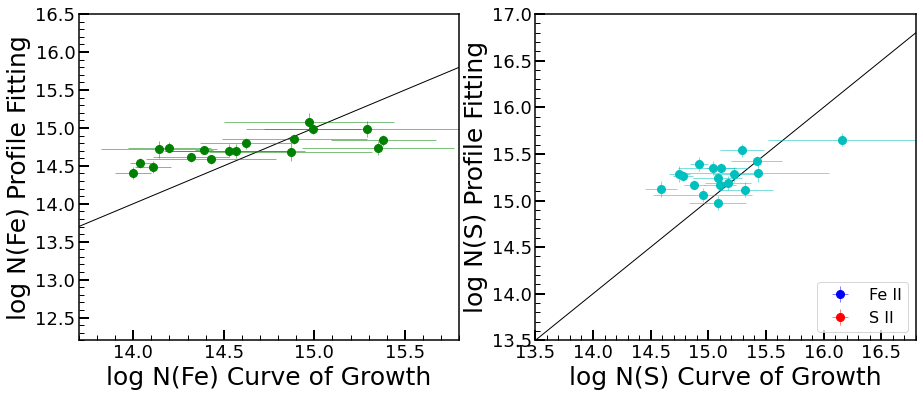

In [111]:
#compare column densities measurements with CoG and Voigt
fig = plt.figure(figsize=(15,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
X = np.linspace(10,20,100)

ax1.plot(X,X, lw=1, c='k')
ax2.plot(X,X, lw=1, c='k')

ax1.set_xlim([13.7, 15.8])
ax2.set_xlim([13.5, 16.8])

ax1.set_ylim([12.2, 16.5])
ax2.set_ylim([13.5, 17.0])

ax1.set_xlabel('log N(Fe) Curve of Growth')
ax2.set_xlabel('log N(S) Curve of Growth')

ax1.set_ylabel('log N(Fe) Profile Fitting')
ax2.set_ylabel('log N(S) Profile Fitting')

stat_s, stat_fe = np.array([]),  np.array([])

for i in range(np.size(new_voigt_fe['Target'])):
    
    j = np.where(metalz['sightline'] == new_voigt_fe['Target'][i])[0]

    ax1.errorbar(metalz['log(N_FeII)'][j][0][0], new_voigt_fe['mean'][i], xerr =metalz['log(N_FeII)'][j][0][1],
                 yerr=new_voigt_fe['sd'][i] ,  fmt='go', ms=8, lw=0.5)


for i in range(np.size(new_voigt_s['Target'])):
    
    j = np.where(metalz['sightline'] == new_voigt_s['Target'][i])[0]


    ax2.errorbar(metalz['log(N_SII)'][j][0][0], new_voigt_s['mean'][i], xerr =metalz['log(N_SII)'][j][0][1],
                 yerr=new_voigt_s['sd'][i] ,  fmt='co', ms=8, lw=0.5)

    
# ax1.plot(X, X-np.std(stat_fe), '--', c='gray')
# ax1.plot(X, X+np.std(stat_fe),'--', c='gray') 

# ax2.plot(X, X-np.std(stat_s), '--', c='gray')
# ax2.plot(X, X+np.std(stat_s),'--', c='gray')
plt.errorbar(0,0, xerr =0,yerr=0 ,  fmt='bo', ms=8, lw=0.5, label='Fe II')
plt.errorbar(0,0,xerr =0,yerr=0, fmt='ro', ms=8, lw=0.5, label='S II')
plt.legend(loc=4)

fig.savefig("cog-pf-comp.png", facecolor='white', bbox_inches='tight')


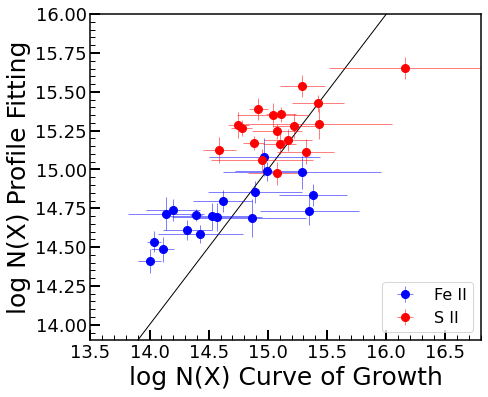

In [112]:
#compare column densities measurements with CoG and Voigt
fig = plt.figure(figsize=(7,6))

X = np.linspace(10,20,100)

plt.plot(X,X, lw=1, c='k')
plt.xlim([13.5, 16.8])
plt.ylim([13.9, 16.0])

plt.xlabel('log N(X) Curve of Growth')
plt.ylabel('log N(X) Profile Fitting')

stat_s, stat_fe = np.array([]),  np.array([])

for i in range(np.size(new_voigt_fe['Target'])):
    
    j = np.where(metalz['sightline'] == new_voigt_fe['Target'][i])[0]

    plt.errorbar(metalz['log(N_FeII)'][j][0][0], new_voigt_fe['mean'][i], xerr =metalz['log(N_FeII)'][j][0][1],
                 yerr=new_voigt_fe['sd'][i] ,  fmt='bo', ms=8, lw=0.5)


for i in range(np.size(new_voigt_s['Target'])):
    
    j = np.where(metalz['sightline'] == new_voigt_s['Target'][i])[0]


    plt.errorbar(metalz['log(N_SII)'][j][0][0], new_voigt_s['mean'][i], xerr =metalz['log(N_SII)'][j][0][1],
                 yerr=new_voigt_s['sd'][i] ,  fmt='ro', ms=8, lw=0.5)

    
# ax1.plot(X, X-np.std(stat_fe), '--', c='gray')
# ax1.plot(X, X+np.std(stat_fe),'--', c='gray') 

# ax2.plot(X, X-np.std(stat_s), '--', c='gray')
# ax2.plot(X, X+np.std(stat_s),'--', c='gray')
plt.errorbar(0,0, xerr =0,yerr=0 ,  fmt='bo', ms=8, lw=0.5, label='Fe II')
plt.errorbar(0,0,xerr =0,yerr=0, fmt='ro', ms=8, lw=0.5, label='S II')
plt.legend(loc=4)

fig.savefig("cog-pf-comp.png", facecolor='white', bbox_inches='tight')


In [104]:
obs = Table.read('metalz-observations.txt', format='csv')

for i in range(np.size(obs['target'])):
    t = (obs['target'][i])
    print(f"{obs['target'][i]} & {obs['grating/cenwave'][i]} & {obs['LP'][i]} & {obs['exptime'][i]} & {obs['PID'][i]} \\\ ")


IC1613-61331 & G130M/1291 & LP4 & 9000 & GO-15880 \\ 
IC1613-61331 & G130M/1309 & LP3 & 2900 & GO-15880 \\ 
IC1613-62024 & G130M/1291 & LP4 & 29904 & GO-15880 \\ 
IC1613-62024 & G130M/1309 & LP3 & 4800 & GO-15880 \\ 
IC1613-64066 & G130M/1291 & LP4 & 4545 & GO-15880 \\ 
IC1613-64066 & G130M/1309 & LP3 & 3177 & GO-15880 \\ 
IC1613-67559 & G130M/1291 & LP4 & 11845 & GO-15880 \\ 
IC1613-67559 & G130M/1309 & LP3 & 2419 & GO-15880 \\ 
IC1613-67684 & G130M/1291 & LP4 & 6900 & GO-15880 \\ 
IC1613-67684 & G130M/1309 & LP3 & 2200 & GO-15880 \\ 
IC1613-A13 & G130M/1291 & LP4 & 1680 & GO-15880 \\ 
IC1613-A13 & G130M/1291 & LP1 & 1911 & GO-12867 \\ 
IC1613-A13 & G130M/1327 & LP1 & 2729 & GO-12867 \\ 
IC1613-B11 & G130M/1291 & LP4 & 4210 & GO-15880 \\ 
IC1613-B11 & G130M/1291 & LP1 & 1852 & GO-12867 \\ 
IC1613-B11 & G130M/1327 & LP1 & 2729 & GO-12867 \\ 
IC1613-B2 & G130M/1291 & LP4 & 3123 & GO-15880 \\ 
IC1613-B3 & G130M/1291 & LP4 & 13150 & GO-15880 \\ 
IC1613-B3 & G130M/1309 & LP3 & 6150 & GO-15

# Other plots

USING LEGENDRE
VEL BOUNDARIES  -592 278
TEST minima  [-584.7003    -579.8979    -575.1247    -570.3222    -560.7759
 -555.9734    -546.427     -532.0489    -524.8745    -512.9269
 -484.22922   -479.42673   -465.07794   -457.9035    -448.35712
 -443.55466   -438.7815    -424.43265   -414.857     -405.28137
 -398.10693   -388.53128   -371.81052   -355.06042   -347.88602
 -335.90915   -331.13596   -316.7871    -300.03705   -290.4614
 -283.28696   -276.11255   -254.58931   -235.46729   -201.96716
 -194.79274   -187.61832   -178.04268   -173.2695    -151.74623
 -146.94377   -142.17058   -137.3974    -132.59494   -127.821754
 -106.2985     -99.12409    -89.54844    -82.374016   -72.79837
  -68.025185   -56.0483     -48.873886   -39.32752    -34.52505
  -10.600567    -5.8273835   22.870285    30.0447      39.620354
   49.196       56.370422    63.544838    75.49243     85.068085
   92.2425     101.81815    108.99257    118.53893    130.51582
  137.69025    152.03908    156.81226    166.38791 

/Users/ahamanowicz/Desktop/METAL-Z/notebooks/spectro.py:897: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  plt.text(200, 1.3, np.str(line) + ' A', fontsize = 18)


AttributeError: module 'numpy' has no attribute 'str'.
`np.str` was a deprecated alias for the builtin `str`. To avoid this error in existing code, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

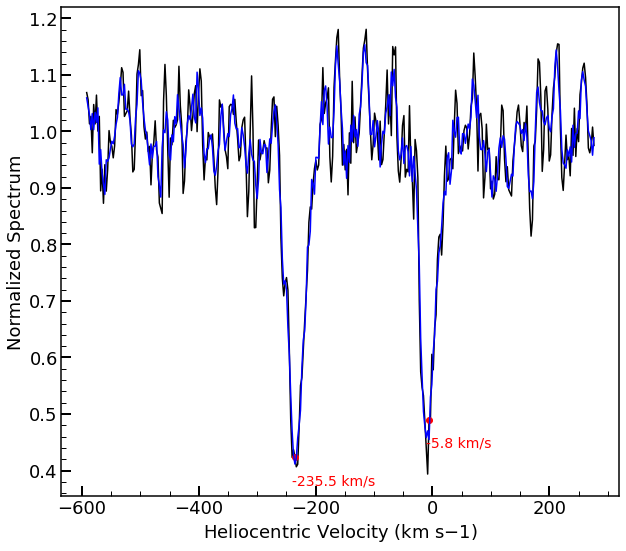

In [124]:
from astropy import convolution

from astropy.io import ascii, fits
cont_min, cont_max = -600, 600

smoothing = convolution.Gaussian1DKernel(1)  # COS smoothing
m = 1
n = 10
vel = v_IC1613
ra,dec = metalz['RA [deg]'][m], metalz['Dec [deg]'][m]
sightline = metalz['sightline'][m]

# spectrum file

file ='/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/' + sightline + '_COS_coadd.fits'
hdul = fits.open(file)
data = hdul[1].data

w = data['WAVELENGTH']
fx = np.array(data['FLUX'])
es = np.array(data['ERROR'])

fs = convolution.convolve(fx, smoothing)

# get the systemic velocity for the sightline from SII lines

lsii = 1250.578

# determine the continuum near the sii line, normalize the spectrum, 
# get the velocity components from the S II 1250 A line

vel_sii, fn_sii, rmsn_sii, vc_sii, fc_sii = spec.find_components(w, fx, lsii, 
        sightline + '_sii_windows.dat',  smooth=5, outname='CONT-FIT/'+sightline+ '_sii_components', 
        main_only=True, vsys=vel, outdir='./')

vel = vc_sii[1]

# get the line parameters 

linename = lines.T[1][n]
line = float(lines.T[2][n])
line_f = float(lines.T[3][n])

# continuum  fit

nanarray = np.isnan(fs)  # mask nans in lfux
notnan = ~ nanarray

flux = fs[notnan]
wav = w[notnan]
err = es[notnan]

cont = spec.cont_fit(w=wav, f=flux, line=line, window_file="CONT-FIT/" + sightline+'_line_' + str(n) + '_cont_win.txt',  
       degree = 3, smooth = 1, outname = "CONT-FIT/" + sightline+'line_' + str(n) + '_fitting_cont_fit', 
    plt_vmin = cont_min, plt_vmax =cont_max, outdir = './',spline=False, show=False)

v = (wav - line) / line * 3.e5
window_file="CONT-FIT/" + sightline+'_line_' + str(n) + '_cont_win.txt'
cont_win = ascii.read(window_file)
vmin = cont_win['col1'].data
vmax = cont_win['col2'].data
print(vmin, vmax)

cont_index = spec.get_cont_index(vmin, vmax, v)

spec_to_fit = flux[cont_index]
vel_to_fit  = v[cont_index]
w_to_fit = wav[cont_index]

fig = plt.figure(figsize=(10,7))
plt.xlim([-600,400])
plt.plot(v, flux, 'k-', label = 'Spectrum')
plt.plot(vel_to_fit, spec_to_fit, 'b.', label = 'Range to fit', alpha = 0.5)
plt.plot(v, cont[1], 'r-', label = 'Continuum')
plt.plot(v, err, 'gray', label='Error array')
plt.ylim([0, 6e-15])
plt.xlabel("Heliocentric Velocity (km s" + r'$^{-1}$)')
plt.ylabel("Flux (" + r'erg s$^{-1}$' + ' ' + r'cm$^{-2}$' + ' ' + r'A$^{-1}$' + ')' )
plt.text(0, np.nanmedian(spec_to_fit)*1.6, str(line) + 'A')
plt.text(0, np.nanmedian(spec_to_fit)*1.8, sightline)
plt.legend(loc=2)
fig.tight_layout()
fig.savefig("cont_fit.png", facecolor='white',  bbox_inches='tight')

In [120]:
def fit_nhi(ra, dec, rw,fs,es,conts,cont_std_index,l0_mw, l0_gal, fit_window_file,grid_mw, grid_gal, smooth = 5, outname = 'nhi_fitting', outdir = './', tau_max = 3., tau_min = 0.3, show=False, galaxy  = 'LMC'):

        """
        Fits a lorentzian profile to the Ly-a 1216 line to determine HI column densities in the galaxy observed and MW
        inputs are:
        ** rw: wavelength array
        ** fs: flux array
        ** es: error array
        ** cont_std_index: index relative to rw, fs, es of where to estimate the continuum
        ** l0_mw: wavlength of the center Ly-a MW absorption
        ** l0_gas: wavelength of the center Ly-a galaxy absorption
        ** fit_window_file: path to text file with the wavelength intervals to be used for fitting the profile
        ** grid_mw: 1D grid of N(HI) values for the MW component
        ** grid_gal: 1D grid of N(HI) values for the gal component

        OUTPUTS:
        best_hi_mw, mx_sigma_mw, p50_mw, c68_unc_mw, best_hi_gal, mx_sigma_gal, p50_gal, c68_unc_gal, fs, chi2
        ** best_hi_mw, gal: best fit N(HI) for MW, gal
        ** best_fit_sigma{low, high}_{mw, gal} low/high uncertainties computed from the 68% confidence level (chi2_min+2.3) around the best fit
        ** p50_mw, gal: N(HI) 50th percentile value for MW, gal
        ** percentiles_sigma{low, high}_{mw,gal}: N(HI) uncertainties computed as p50-16% and 84%-p50 (68% confidence interval centered on p50)
        ** fs: input spectrum
        ** chi2: chi2!
        """

        l0 = np.double(1215.67)
        vmw = 3.e5*(l0_mw-l0)/l0
        vgal = 3.e5*(l0_gal-l0)/l0

        target = outname.split('_')[0]

        print("TAU_MAX ", tau_max)
        print("TAU_MIN ", tau_min)

        sampling_mw = np.median(np.abs(grid_mw-np.roll(grid_mw,1)))
        sampling_gal = np.median(np.abs(grid_gal-np.roll(grid_gal,1)))

        nmw = len(grid_mw)
        ngal = len(grid_gal)

        ln_prob = np.zeros([nmw, ngal], dtype = 'float32')
        chi2 = np.zeros([nmw, ngal], dtype = 'float32')

        if os.path.isfile(fit_window_file)==False:
            print("CREATE WINDOWS FOR CHI2 ESTIMATION")
            plt.plot(rw, fs, 'k')
            #plt.plot(rw, es*np.exp(3.), 'b')
            plt.xlim([1130, 1320])
            good = np.where((np.isnan(fs)==False) & (np.isinf(fs)==False))
            plt.ylim([0, 2.5*np.nanmedian(fs[good])])
            plt.show()

        t = ascii.read(fit_window_file)
        wmin = t['col1'].data
        wmax = t['col2'].data

        #implemented the N(HI) depdendent shift in teh scattering cross section from Lee+2003
        sigma_mw = 4.26e-20/(6.04e-10 + (np.double(rw)-l0_mw)**2)*(1.-1.792*(np.double(rw)-l0_mw)/l0_mw)
        sigma_gal = 4.26e-20/(6.04e-10 + (np.double(rw)-l0_gal)**2)*(1.-1.792*(np.double(rw)-l0_gal)/l0_gal)

        #fit_index= get_cont_index(wmin, wmax,rw)

        for i in range(nmw):
            for j in range(ngal):

                hi_mw = grid_mw[i]
                hi_gal = grid_gal[j]

                tau_mw = 10.**(hi_mw)*sigma_mw
                tau_gal= 10.**(hi_gal)*sigma_gal
                correction = np.exp(tau_mw)*np.exp(tau_gal)
                tau = np.log(correction)

                corr_f = fs*correction
                corr_e = es*correction

                #Fixed the windows, does nto depend on tau anymore
                fit_index = spectro.get_fit_index(rw, wmin, wmax, tau, tau_max = tau_max, tau_min = tau_min)

                if len(fit_index)>0:

                    #print("OK ", grid_mw[i], grid_gal[j])

                    spec_to_fit = fs[fit_index]
                    err_to_fit = es[fit_index]
                    tau_to_fit = tau[fit_index]
                    w_to_fit = rw[fit_index]

                    cont_to_fit = conts[fit_index]

                    #if grid_gal[j]>=20.:
                    #    plt.plot(w_to_fit, spec_to_fit, 'k.')
                    #    plt.plot(w_to_fit, cont_to_fit, 'r.')
                    #    this_model = cont_to_fit*np.exp(-tau_to_fit)
                    #    plt.plot(w_to_fit, this_model, 'g.')
                    #    plt.show()


                    #for COS, teh gap can be nan, so filter it out

                    valid = np.where((np.isnan(spec_to_fit) ==False) & (np.isinf(spec_to_fit)==False) & (err_to_fit > 0.))
                    valid = valid[0]
                    n = len(valid)

                    chi2[i,j] = np.double(np.nansum((spec_to_fit[valid] - cont_to_fit[valid]*np.exp(-tau_to_fit[valid]))**2/err_to_fit[valid]**2))
                    #print("DEBUG ", grid_mw[i], grid_gal[j], chi2[i,j])

                else:
                    #print("PB ", grid_mw[i], grid_gal[j])
                    chi2[i,j] = 100000000.

                ln_prob[i,j] = - chi2[i,j]/2.
        #the max is too high and turns into nan numerically, so subtract teh max, then normalize
        ln_prob = ln_prob-np.max(ln_prob)

        ln_prob = np.double(ln_prob) + np.log(1.) - np.log(np.sum(np.exp(np.double(ln_prob))))#- np.log(np.median(grid_mw-np.roll(grid_mw,1)))
        prob= np.exp(np.double(ln_prob))

        min_index = np.argmax(ln_prob)
        ij = np.unravel_index(min_index, ln_prob.shape)

        best_hi_mw = grid_mw[ij[0]]
        best_hi_gal = grid_gal[ij[1]]

        tau_mw = 10.**(best_hi_mw)*sigma_mw
        tau_gal= 10.**(best_hi_gal)*sigma_gal
        correction = np.exp(tau_mw)*np.exp(tau_gal)
        tau = np.log(correction)
        #fcorr = f*correction
        fcorrs = fs*correction
        cont_corr = conts*np.exp(-tau)
        bad = np.where(tau > 10)
        #fcorr[bad] = np.nan
        fcorrs[bad] = np.nan

        fit_index = spectro.get_fit_index(rw, wmin, wmax, tau, tau_max = tau_max,tau_min= tau_min)
        #fit_index = get_cont_index(wmin, wmax, w)
        spec_to_fit = fs[fit_index]
        w_to_fit = rw[fit_index]
        cont_to_fit = conts[fit_index]

        hdu = fits.PrimaryHDU(ln_prob)
        hdu2 = fits.ImageHDU(chi2 - np.nanmin(chi2))
        hdulist = fits.HDUList([hdu, hdu2])
        hdulist.writeto(outname + "_ln_prob.fits", overwrite=True)
        #bad = np.where((np.isnan(prob) ==True) | (np.isinf(prob)==True))
        #prob[bad] = 0.
        mx_pdf_mw = np.nanmax(prob, axis = 1)
        mx_pdf_gal = np.nanmax(prob, axis = 0)
        mx_pdf_mw = mx_pdf_mw/trapezoid(mx_pdf_mw, grid_mw)   #np.nansum(mx_pdf_mw)
        mx_pdf_gal = mx_pdf_gal/trapezoid(mx_pdf_gal, grid_gal)#np.nansum(mx_pdf_gal)

        int_pdf_mw = trapezoid(prob, grid_gal, axis = 1)#np.nansum(prob, axis = 1)
        int_pdf_gal = trapezoid(prob, grid_mw, axis = 0)#np.nansum(prob, axis = 0)
        int_pdf_mw = int_pdf_mw/trapezoid(int_pdf_mw, grid_mw)#np.nansum(int_pdf_mw)
        int_pdf_gal = int_pdf_gal/trapezoid(int_pdf_gal, grid_gal)#np.nansum(int_pdf_gal)

        #write the _PDFs
        pdf_table_mw = Table()
        pdf_table_mw['N(HI)'] = grid_mw
        pdf_table_mw['MX_PDF'] = mx_pdf_mw
        pdf_table_mw['INT_PDF'] = int_pdf_mw
        pdf_mw_file = outdir + outname + '_mw_pdf.dat'
        ascii.write(pdf_table_mw, pdf_mw_file, format = 'csv', overwrite=True)

        pdf_table_gal = Table()
        pdf_table_gal['N(HI)'] = grid_gal
        pdf_table_gal['MX_PDF'] = mx_pdf_gal
        pdf_table_gal['INT_PDF'] = int_pdf_gal

        pdf_gal_file = outdir + outname + '_gal_pdf.dat'
        ascii.write(pdf_table_gal, pdf_gal_file, format = 'csv', overwrite=True)


        #Now determine uncertaintiesin 2 ways.
        #First, get the contour of chi2 = chi2min + 2.3 (0.68 confidence interval, and just report the left and right distance from best fit in each direction)
        #second, compute the percentiles of the marginalized _PDFs

        #method 1: use the best fit, adn distance to the min/max (X,Y) in the chi2 contour lower than chi2min + 2.3

        chi2_min = np.nanmin(chi2)
        confidence_interval = np.where(chi2 <= chi2_min + 2.3)
        #confidence_interval2 = np.unravel_index(confidence_interval1[0], chi2.shape)
        nhmin_mw = grid_mw[np.min(confidence_interval[0])]
        nhmax_mw = grid_mw[np.max(confidence_interval[0])]

        nhmin_gal = grid_gal[np.min(confidence_interval[1])]
        nhmax_gal = grid_gal[np.max(confidence_interval[1])]

        best_fit_sigmalow_mw = best_hi_mw - nhmin_mw
        best_fit_sigmahigh_mw = nhmax_mw - best_hi_mw

        best_fit_sigmalow_gal = best_hi_gal - nhmin_gal
        best_fit_sigmahigh_gal = nhmax_gal - best_hi_gal

        #now method 2: use the percentiles of the marginalized PDFs.


        percentiles_mw, xpercentiles_mw = spectro.get_percentiles(grid_mw, int_pdf_mw, percentiles =[0.16, 0.32, 0.5, 0.68, 0.84] )
        percentiles_gal, xpercentiles_gal = spectro.get_percentiles(grid_gal, int_pdf_gal, percentiles =[0.16, 0.32, 0.5, 0.68, 0.84] )

        p50_mw = xpercentiles_mw[2]
        p50_gal = xpercentiles_gal[2]

        percentiles_sigmalow_mw = xpercentiles_mw[2] - xpercentiles_mw[0]
        percentiles_sigmahigh_mw = xpercentiles_mw[4] - xpercentiles_mw[2]

        percentiles_sigmalow_gal = xpercentiles_gal[2] - xpercentiles_gal[0]
        percentiles_sigmahigh_gal = xpercentiles_gal[4] - xpercentiles_gal[2]

        print("RESULT MW ", best_hi_mw, best_fit_sigmalow_mw, best_fit_sigmahigh_mw , p50_mw, percentiles_sigmalow_mw ,percentiles_sigmahigh_mw )
        print("RESULT " + galaxy, best_hi_gal, best_fit_sigmalow_gal, best_fit_sigmahigh_gal , p50_gal, percentiles_sigmalow_gal ,percentiles_sigmahigh_gal)

        #Now turn large unc into limits:
        l_nhi_mw = ''
        l_nhi_gal = ''
        if best_hi_mw == np.min(grid_mw):
            l_nhi_mw = '<'
            best_hi_mw = best_hi_mw + best_fit_sigmahigh_mw
        if best_hi_gal == np.min(grid_gal):
            l_nhi_gal = '<'
            best_hi_gal = best_hi_gal + best_fit_sigmahigh_gal



        nhi_mw_21cm = np.log10(spectro.get_mw_nhi21cm(ra, dec))

        plt.clf()
        plt.close()
        fig = plt.figure(figsize = (10,9))
        plt.plot(grid_mw, int_pdf_mw, 'k', label  = "MW")
        plt.plot(grid_gal, int_pdf_gal, 'r' , label = galaxy)
        plt.plot(np.zeros(11) + nhi_mw_21cm, np.arange(11)*np.max(int_pdf_gal)/10., '--', color = 'lightgray', label = 'MW 21 cm')
        plt.plot(np.zeros(11) + best_hi_mw, np.arange(11)*np.max(int_pdf_gal)/10., '--', color = 'black', label = 'MW best fit', alpha = 0.5)
        if l_nhi_mw == '<':
            plt.errorbar([best_hi_mw], np.max(int_pdf_gal), fmt = '.', xerr = 0.5, xuplims = [1], color = 'black', alpha= 0.5)

        if l_nhi_gal == '<':
            plt.errorbar([best_hi_gal], np.max(int_pdf_gal), fmt = '.', xerr = 0.5, xuplims = [1], color = 'red', alpha= 0.5)
        plt.plot(np.zeros(11) + best_hi_gal, np.arange(11)*np.max(int_pdf_gal)/10., '--', color = 'red', label = '{} best fit'.format(galaxy), alpha = 0.5)
        plt.xlabel("log N(HI) (cm" + r'$^{-2}$)', fontsize = 18)
        plt.ylabel("PDF", fontsize = 18)
        plt.legend(fontsize = 18)
        plt.text(min(grid_mw) + 0.1, max(int_pdf_mw)*0.5, target, fontsize = 18)
        #plt.yscale('log')
        fig.tight_layout()
        fig = plt.gcf()
        fig.savefig(outdir + outname + "_pdfs.pdf", format = "pdf", dpi = 1000)
        #plt.show()

        plt.clf()
        plt.close()

        #fig,ax = plt.subplots(figsize = (11,9))
        #im=ax.imshow(prob, vmin = np.max(prob)/10., vmax = np.max(prob), origin = 'lower', extent = [np.min(grid_gal), np.max(grid_gal), np.min(grid_mw), np.max(grid_mw)], cmap = 'gist_stern_r')
        #ax.contour(grid_gal, grid_mw, prob, levels = [0.6*np.max(prob)], colors  = ['magenta'])
        #ax.set_xlabel("LMC log N(HI) " + r'(cm$^{-2}$)', fontsize = 18)
        #ax.set_ylabel("MW log N(HI) " + r'(cm$^{-2}$)', fontsize = 18)
        #ax.text(min(grid_gal) + 0.1, min(grid_mw)+0.1, target, fontsize = 18)
        #cbaxes = inset_axes(ax, width="80%", height="5%", loc=9)
        #cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
        ##cbar =fig.colorbar(im,orientation='vertical', fraction  = 0.04, ax = ax)
        #cbar.set_label("p = exp(-" + r'$\chi^2/2)$', fontsize = 18)
        #fig.subplots_adjust(bottom = 0.1, top = 0.95, left = 0.1, right = 0.85)
        #plt.savefig(outdir + outname + '_prob.pdf', format = 'pdf', dpi = 1000)
        #plt.clf()
        #plt.close()

        fig = plt.figure(figsize = (11,11))
        grid = plt.GridSpec(5, 5, hspace=0., wspace=0.)
        main_ax = fig.add_subplot(grid[:-1,1:])
        y_hist = fig.add_subplot(grid[:-1,0], xticklabels = [], sharey=main_ax)
        x_hist = fig.add_subplot(grid[-1,1:], yticklabels = [], sharex=main_ax)

        # scatter points on the main axes
        im = main_ax.imshow(prob, vmin = 0., vmax = np.max(prob), origin = 'lower', extent = [np.min(grid_gal), np.max(grid_gal), np.min(grid_mw), np.max(grid_mw)], cmap = 'gist_stern_r')
        #im = main_ax.imshow(prob, vmin = np, vmax = np.nanmax(chi2), origin = 'lower', extent = [np.min(grid_gal), np.max(grid_gal), np.min(grid_mw), np.max(grid_mw)], cmap = 'gist_stern_r')
        main_ax.contour(grid_gal, grid_mw, prob, levels = [np.nanmax(prob)*np.exp(-2.3/2.)], colors  = ['orange'])
        main_ax.axhline(y = nhi_mw_21cm, linestyle = '--', color = 'lightgray')
        main_ax.axhline(y = best_hi_mw, linestyle = '--', color = 'red', alpha = 0.5)
        main_ax.axvline(x = best_hi_gal, linestyle = '--', color = 'red', alpha = 0.5)



        main_ax.text(min(grid_gal) + 0.1, min(grid_mw)+0.1, target, fontsize = 18)
        main_ax.set_xticklabels([])
        main_ax.set_yticklabels([])
        cbaxes = inset_axes(main_ax, width="80%", height="5%", loc=9)
        cbar = fig.colorbar(im,cax=cbaxes, orientation='horizontal')
        #cbar =fig.colorbar(im,orientation='horizontal', fraction  = 0.04, gap = -0.04, ax = main_ax)
        cbar.set_label("p ~ exp(-" + r'$\chi^2/2)$', fontsize = 18)

        #a zoom panel
        zax = plt.axes([0.65, 0.65, 0.2, 0.2])
        delta_mw = min([percentiles_sigmalow_mw/sampling_mw*5., 0.5/sampling_mw])
        delta_gal = min([percentiles_sigmalow_gal/sampling_gal*5.,0.5/sampling_gal])
        xmin_mw = int(max([ij[0]-delta_mw,0]))
        xmax_mw = int(min([ij[0] + delta_mw, nmw]))
        xmin_gal = int(max([ij[1]-delta_gal,0]))
        xmax_gal = int(min([ij[1] + delta_gal, ngal]))

        zax.imshow(prob[xmin_mw:xmax_mw, xmin_gal:xmax_gal], vmin = 0., vmax = np.nanmax(prob), origin = 'lower', extent = [np.min(grid_gal[xmin_gal:xmax_gal]), np.max(grid_gal[xmin_gal:xmax_gal]), np.min(grid_mw[xmin_mw:xmax_mw]), np.max(grid_mw[xmin_mw:xmax_mw])], cmap = 'gist_stern_r')
        zax.contour(grid_gal[xmin_gal:xmax_gal], grid_mw[xmin_mw:xmax_mw], prob[xmin_mw:xmax_mw, xmin_gal:xmax_gal], levels = [np.nanmax(prob)*np.exp(-2.3/2.)], colors  = ['orange'])

        # histogram on the attached axes
        y_hist.plot(int_pdf_mw,grid_mw, 'r')
        y_hist.plot(np.arange(11)/10.*np.max(int_pdf_mw), np.zeros(11) + nhi_mw_21cm, '--', color = 'lightgray')
        y_hist.plot(np.arange(11)/10.*np.max(int_pdf_mw), np.zeros(11) + best_hi_mw, '--', color = 'black', alpha = 0.5)
        if l_nhi_mw == '<':
            y_hist.errorbar([0.1], [best_hi_mw], yerr = 0.5, uplims =[1], color = 'black', alpha = 0.5)

        #y_hist.xaxis.tick_top()
        #y_hist.set_ylim([np.min(grid_mw), np.max(grid_mw)])
        y_hist.set_ylabel("MW log N(HI) " + r'(cm$^{-2}$)', fontsize = 18)
        y_hist.set_yticks(np.arange(19,22.5, 0.5))
        y_hist.set_yticklabels(np.arange(19,22.5, 0.5))
        y_hist.set_xlabel("PDF", fontsize = 18)
        y_hist.invert_xaxis()

        x_hist.plot(grid_gal,int_pdf_gal, 'r')
        x_hist.plot(np.zeros(11) + best_hi_gal,np.arange(11)/10.*np.max(int_pdf_gal),  '--', color = 'black', alpha = 0.5)
        if l_nhi_gal == '<':
            x_hist.errorbar([best_hi_gal], [np.max(int_pdf_gal)], xerr = 0.5, xuplims =[1], color = 'black', alpha = 0.5)
        x_hist.set_xlabel(galaxy + " log N(HI) " + r'(cm$^{-2}$)', fontsize = 18)
        x_hist.set_xticks(np.arange(19,22.5, 0.5))
        x_hist.set_xticklabels(np.arange(19,22.5, 0.5))
        x_hist.set_ylabel("PDF", fontsize = 18)
        x_hist.invert_yaxis()

        fig.subplots_adjust(bottom = 0.1, top = 0.95, left = 0.1, right = 0.95)
        plt.savefig(outdir + outname + '_prob.pdf', format = 'pdf', dpi = 1000)
        plt.clf()
        plt.close()

        good = np.where((np.isnan(fs) ==False) & (np.isinf(fs)==False))
        good = good[0]

        fig = plt.figure(figsize = (15, 8))
        plt.plot(rw, fs, 'k', label = 'Spectrum')
        plt.plot(rw, es, '-', color = 'gray', label = 'Error')
        plt.plot(rw[cont_std_index], fs[cont_std_index], '.', color = 'magenta', label = 'Continuum est.')
        plt.plot(w_to_fit, fs[fit_index], 'b.',  label = r'$\chi^2$ minimalization range')
        #plt.plot(w_to_fit, spec_to_fit, 'b.', label = r'$\chi^2$ minimzation range')
        plt.plot(rw, fcorrs, 'r', alpha = 0.3, label = 'Reconstructed spectrum (x ' + r'e$^{\tau}$' + ')')
        plt.plot(rw[fit_index], fcorrs[fit_index], 'b.', alpha = 0.5)
        plt.plot(rw, conts, 'g', label = 'Continuum')
        plt.plot(rw, cont_corr, 'g--', label = 'Best-fit Model')
        #plt.plot(w_to_fit, fs[fit_index], 'r.', alpha = 0.7)
        #plt.plot(rw, conts*np.log10(-tau_mw), 'y--')
        plt.plot(rw, conts*np.log10(-tau_gal), 'r--')

        plt.xlim([1130., 1300])
        #plt.yscale('log')
        plt.ylim([0.*np.nanmedian(fs[good]), 3.*np.nanmedian(fs[good])])
        plt.xlabel("Wavelength (Angstroms)", fontsize = 18)
        plt.ylabel("Flux (" + r'erg s$^{-1}$' + ' ' + r'cm$^{-2}$' + ' ' + r'A$^{-1}$' + ')' , fontsize = 18)
        plt.legend(fontsize = 16, loc = 'upper right')
        plt.text(1150, 2.8*np.nanmedian(fs[good]), target, fontsize = 18)
        plt.text(1150, 2.6*np.nanmedian(fs[good]), 'Velocities: ' + '{:3.0f}'.format(vmw) + ', '  + '{:3.0f}'.format(vgal) + ' ' + r'km s$^{-1}$', fontsize = 18)
        plt.text(1150, 2.4*np.nanmedian(fs[good]), 'log N(HI): ' + '{:4.2f}'.format(best_hi_mw) + ', '  + '{:4.2f}'.format(best_hi_gal) + ' ' + r'cm$^{-2}$', fontsize = 18)

        fig.tight_layout()
        fig = plt.gcf()
        fig.savefig(outdir + outname + '_fitted_spectra.pdf', format = 'pdf', dpi = 1000)
        #plt.show()
        plt.clf()
        plt.close()



        return(nhi_mw_21cm, l_nhi_mw, best_hi_mw, best_fit_sigmalow_mw, best_fit_sigmahigh_mw, p50_mw, percentiles_sigmalow_mw,percentiles_sigmahigh_mw, l_nhi_gal, best_hi_gal, best_fit_sigmalow_gal, best_fit_sigmahigh_gal, p50_gal, percentiles_sigmalow_gal,percentiles_sigmahigh_gal, fs, chi2, rw, cont_corr, tau)



In [121]:
import spectro as spectro
def nhi_fit_proc(ra, dec, spec_file, type_ascii = False,  target = '', smooth_sii = 3, smooth_hi = 9,outdir = './', tau_max = 3, show=False, tau_min  = 0.3, sampling = 0.01, vsys = 262., galaxy = 'LMC', use_vsys=False):
    """
    Main function to fit the HI lorentzian profile and measure N(HI) for the MW and the galaxy observed
    INPUTS:
    ** spec_file: path to spectrum file (fits or ascii, if ascii, set type_ascii=True)
    ** target: name of target (for filename purposes)
    ** vsys: systemic velocity of galaxy. The code will measure the velocity from S II lines if use_vsys is False (default). Otherwise, it will use the input systemic velocity
    ** sampling: sampling of log N(HI) grid. Default is 0.01 dex
    ** tau_min, tau_max; min/max tau included in fit (if tau is too high, there's not flux, if it's too small, measurements arent' meaningful
    """

    if type_ascii==False:
        specf = spectro.spectrum_fits_to_ascii(spec_file)
    else:
        specf = spec_file

    spec = ascii.read(specf)

    ws = spec['WAVELENGTH'].data
    fs = spec['FLUX'].data
    es  = spec['ERROR'].data

    #mask the nans
    
    nanarray = np.isnan(fs) #mask nans in lfux
    notnan = ~ nanarray

    f = fs[notnan]
    w = ws[notnan]
    e = es[notnan]
    
    l0 = np.double(1215.67) #Lyman alpha
    lsii = 1250.578

    if use_vsys==False:
    #determinethe continuum near the sii line, normalize the spectrum, get the velocity components from the S II 1250 A line
        vel_sii, fn_sii, rmsn_sii, vc_sii, fc_sii = spectro.find_components(w, f, lsii, "HI-FIT/" + target + '_sii_windows.dat',  smooth = smooth_sii, outname =target+ '_sii_components', main_only=True, vsys = vsys, outdir  = outdir)
    else:
        vc_sii = [0, vsys]
    #the MW component is the one at low evelocity
    ind_sort = np.argsort(vc_sii)

    if vsys > 50:
        v_mw = vc_sii[ind_sort[0]]
        v_gal = vc_sii[ind_sort[1]]
    else:
        v_mw = vc_sii[ind_sort[1]]
        v_gal = vc_sii[ind_sort[0]]
        print("VELOCITIES ", v_mw, v_gal)
    l0_mw = l0*(1. + v_mw/3.e5)
    l0_gal = l0*(1. + v_gal/3.e5)

    #fit teh continuum to lyman-alpha
    vel_hi,cont_hi, rms_hi, fn_hi, rmsn_hi = spectro.cont_fit(w, f, l0 , "HI-FIT/" + target + '_lyman_alpha_windows.dat', smooth = 5, plt_vmin = -20000., plt_vmax= 28000., degree=1, outname = target +  '_hi_cont_fit',outdir   = outdir, show=show)

    #find the best fit to the continuum in fit windows

    grid_mw = np.arange(18.5, 22.5, sampling)
    grid_gal = np.arange(18.5, 22.5, sampling)

    if smooth_hi > 1:
        wmin = np.min(w)
        wmax = np.max(w)
        disp = np.median(np.abs(w-np.roll(w,1)))

        rdisp = disp*smooth_hi
        rw = np.arange(wmin + 1, wmax-1, rdisp)
        fs, es = spectres(rw, w, f, e)
        conts, ecs = spectres(rw, w, cont_hi, np.zeros_like(cont_hi))

    else:
        rw = w
        fs = f
        conts=cont_hi
        es= e

    #Get the rms between rebinned spetrum and continuum
    #If I forward model to estimate chi2, I want error on measurement
    vel_hel = 3.e5*(rw-l0)/l0
    cont_win =  ascii.read("HI-FIT/" + target + '_lyman_alpha_windows.dat')
    vmin = cont_win['col1'].data
    vmax = cont_win['col2'].data

    cont_std_index = spectro.get_cont_index(vmin, vmax, vel_hel)

    #the error array does not include noise due to weak stellar lines. We want to account for this, so measure teh "stellar line noise" empirically from the standard deviation of teh continuum and scale the error array accordingly. This wil also include fixed pattern noise.
    rms = np.nanstd((fs[cont_std_index] - conts[cont_std_index]))
    scaling_err = rms/np.median(es[cont_std_index])
    print("SCALING ERR ", scaling_err)
    es = es*scaling_err
    #es = np.zeros_like(es) + rms
    #print("RMS ", rms)

    #plt.clf()
    #plt.close()
    #plt.plot(fs[cont_std_index], np.roll(fs[cont_std_index],1), 'k.')
    #plt.show()
    #plt.clf()
    #plt.close()

    #best_hi_mw, mx_sigma_mw, p50_mw, c68_unc_mw, best_hi_gal, mx_sigma_gal, p50_gal, c68_unc_gal, fcorr, chi2 = fit_nhi(rw,fs,es,conts,cont_std_index, l0_mw, l0_gal, target + '_lyman_alpha_fit_windows.dat',grid_mw, grid_gal, smooth = smooth_hi, outname = target + '_hi_fit', outdir = outdir, tau_max = tau_max, tau_min = tau_min, galaxy = galaxy)
    nhi_mw_21cm, l_nhi_mw, best_hi_mw, best_fit_sigmalow_mw, best_fit_sigmahigh_mw, p50_mw, percentiles_sigmalow_mw,percentiles_sigmahigh_mw, l_nhi_gal, best_hi_gal, best_fit_sigmalow_gal, best_fit_sigmahigh_gal, p50_gal, percentiles_sigmalow_gal,percentiles_sigmahigh_gal, flux, chi2, wavelength, best_fit_model, tau = fit_nhi(ra, dec, rw,fs,es,conts,cont_std_index, l0_mw, l0_gal, "HI-FIT/" + target + '_lyman_alpha_fit_windows.dat',grid_mw, grid_gal, smooth = smooth_hi, outname = target + '_hi_fit2022', outdir = outdir, tau_max = tau_max, tau_min = tau_min, galaxy = galaxy)


    t = Table()
    #t['wavelength'] = w
    #t['flux'] = f
    t['rebinned wavelength'] = rw
    t['rebinned flux'] = flux
    t['model'] = best_fit_model
    t['tau'] = tau

    ascii.write(t, 'hi_model_{}.dat'.format(target), overwrite=True)

    return(nhi_mw_21cm, l_nhi_mw, best_hi_mw, best_fit_sigmalow_mw, best_fit_sigmahigh_mw, p50_mw, percentiles_sigmalow_mw,percentiles_sigmahigh_mw, l_nhi_gal, best_hi_gal, best_fit_sigmalow_gal, best_fit_sigmahigh_gal, p50_gal, percentiles_sigmalow_gal,percentiles_sigmahigh_gal, flux, chi2, v_mw, v_gal, wavelength, best_fit_model, tau)


IC1613-62024 ['IC1613-62024_COS_coadd.fits']


VELOCITIES  0 -233
USING LEGENDRE


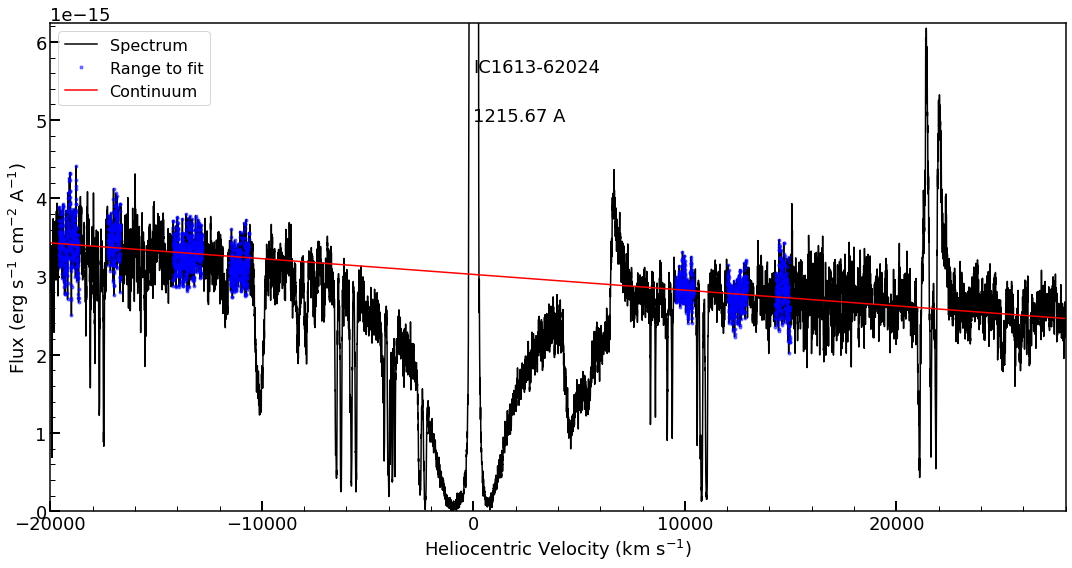

SCALING ERR  0.8610032909638297
TAU_MAX  100
TAU_MIN  0


<ipython-input-120-df0a3a548d13>:71: RuntimeWarning: overflow encountered in exp
  correction = np.exp(tau_mw)*np.exp(tau_gal)
<ipython-input-120-df0a3a548d13>:71: RuntimeWarning: overflow encountered in multiply
  correction = np.exp(tau_mw)*np.exp(tau_gal)
<ipython-input-120-df0a3a548d13>:127: RuntimeWarning: overflow encountered in exp
  correction = np.exp(tau_mw)*np.exp(tau_gal)


RESULT MW  20.340000000000288 0.13000000000002032 0.14000000000002188 20.328323861036953 0.1266132152963486 0.09689838084274527
RESULT IC 1613 21.0600000000004 0.03000000000000469 0.020000000000003126 21.0510383555643 0.023161791920561114 0.022718908362680423
603 354


<ipython-input-120-df0a3a548d13>:350: RuntimeWarning: invalid value encountered in log10
  plt.plot(rw, conts*np.log10(-tau_gal), 'r--')


In [122]:
import fnmatch
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from spectres import spectres
from scipy.integrate import trapezoid, cumulative_trapezoid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import ascii
# HI fitting plot
# galaxy
galaxy = 'IC 1613'
vsys = v_IC1613

box = '/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/COADDS/'
smoothing10 = Gaussian1DKernel(10)
smoothing2 = Gaussian1DKernel(2)

# choose the sightline
J = 1
sightline = metalz['sightline'][J]
ra,dec = metalz['RA [deg]'][J], metalz['Dec [deg]'][J]

# find the spectrum
file = fnmatch.filter(os.listdir(box), "*" + sightline + "*.fits")
print(sightline, file)

# read the spectrum
hdul = fits.open(box + file[0])
data = hdul[1].data
wl = data['WAVELENGTH']
fx = np.array(data['FLUX'])
err = np.array(data['ERROR'])
fx_con10 = convolve(fx, smoothing10)
fx_con2 = convolve(fx, smoothing2)

# fit the HI
plt.figure(1, figsize=(15, 8))      
nhi = nhi_fit_proc(spec_file=box + file[0], type_ascii = False,  target=sightline, smooth_sii = 5, 
            smooth_hi=8,outdir = './', tau_max = 100, show=True, tau_min=0, sampling = 0.01, vsys = vsys, 
            galaxy =galaxy, use_vsys=True, ra=ra, dec=dec)


# Appendix

In [119]:
N = np.arange(10, 20, .01)  # logN 10 - 20 
b = np.arange(5, 100, .1)  # 5 -100
LF_m = np.linspace(-8, -4, 100)
fsii = np.array([0.809, 1.113, 1.295])  # SII 1250, 1253, 1259
ffeii = np.array([0.661, 1.342, 1.978])  # Fe II 1142, 1143, 1144, 1608 -1.968
lf = [fsii,ffeii]

In [120]:
# all lines on one plot - Fe II limited (no 1608)

def stack_plot(sightline_no=1, vel_gal=0, smooth=5, xlim= [-200, 200]):
    
    """ Create a stack plot of all observed lines aligned and centered at system velocity """
    
    s = smooth
    i = sightline_no
    sightline = metalz['sightline'][i]
    ra,dec= metalz['RA [deg]'][i], metalz['Dec [deg]'][i]
    print(sightline)

    # get the spectral snippets
    # directory = "/Users/ahamanowicz/Library/CloudStorage/Box-Box/METALZ/METAL-Z_voigt/"
    # the files for tthe paper are stored locally 
    
    files = os.listdir()

    sii_files = [b for b in files if "dat" in b and "SII" in b and sightline in b]
    feii_files = [b for b in files if "dat" in b and "FeII" in b and sightline in b]

    print(sii_files, feii_files)

    # to plot velocities we will use the same line as the velculp choices as the one used for limits. So for IC1613 -> SII 1529
    
    # read a clump velocity from SI II 1259

    a = np.where(t['sightline'] == sightline)
    ta = t[a]
    b = np.where(ta['linewav'] == float(lines.T[2][11]))[0]
    velsii = ta['v_clump'][b][0]
    vlim = ta['v_lim'][b][0]

    # if Fe II 1608 avaliable add a subplot
    
    n = 7 if sightline_no in [5,9,17,18] else 6
          
    if vel_gal == v_SexA:  # limit number of subplots for Sextans A as S II 1259 is not observed (blend)
        
        n = n - 1
        N = 2
    else: N = 3
      
    s = 5  # smoothing
    custom_xlim = xlim  # set xlim
    
    fig, axs = plt.subplots(n,1, sharex=True, figsize=(7,18) )
    fig.subplots_adjust(hspace=0)

    # SII lines
    line = 'SII'
    
    for j,i in zip(range(N), range(0,N)):
        
        data = np.loadtxt(sii_files[j], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
        wav, flux, err, cont_err = data.T[0], data.T[1], data.T[2], data.T[3]
        d = sii_files[j].split("_")
        line0 = float(d[-1].split(".dat")[0])
        print(line0)
        
        vel = (wav -line0) / line0 * 3.e5
        vel_lsr = spec.helio_to_lsr(vel,ra,dec )  # convert to lsr
        f = convolve(flux, Box1DKernel(s))
        vel0 = vel_lsr - velsii  # corrected for local velocity of the galaxy

        # mark the region used in EW calculations
        axs[i].plot(vel0, f, c='k', lw=3)
        axs[i].plot(vel0, err, c='grey', lw=1)
        k = np.where((vel0 > -vlim ) & (vel0 < vlim))[0]
        axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

        # print the measured Wr on plot
        d = np.where(ta['linewav'] == line0)[0]
        print(d)
        W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]
        
        axs[i].annotate( line+ " " + str(int(line0)), (0.03, 0.87), xycoords='axes fraction', fontsize=16)
        axs[i].annotate( "\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)),
                        (0.03, 0.78), xycoords='axes fraction', fontsize=14)
        axs[i].axvline(vlim, ls='--', c='gray')
        axs[i].axvline(-vlim, ls='--', c='gray')
        axs[i].axhline(1, ls=':', c='gray')

    # Fe II lines
    print(feii_files)
    line = 'FeII'

    # if no 1608

    data = np.loadtxt(feii_files[0], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
    wav, flux, err, cont_err = data.T[0], data.T[1], data.T[2], data.T[3]

    # get veclump
    line = "Fe II"
    j = 0
    k = 2

    line0 = float(lines.T[2][k])
    print(line0)
    vel = (wav - line0) / line0 * 3.e5
    vel_lsr = spec.helio_to_lsr(vel,ra,dec)  #convert to lsr
    f = convolve(flux, Box1DKernel(3))

    velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
    print(velclump)
    
    if np.size(velclump) > 0:
        velfeii = velclump[0]
    else: velfeii = velsii
        
    mm = np.where(ta['linewav'] ==  1142.366)[0]
    print(mm)
    velfeii = velsii
    
    for line0, i in zip([lines.T[2][0],lines.T[2][1],lines.T[2][2]], range(N,n)):

        print(line0)
        line0 = float(line0)
        vel = (wav - line0) / line0 * 3.e5
        vel_lsr = spec.helio_to_lsr(vel,ra,dec ) # convert to lsr
        f = convolve(flux, Box1DKernel(s))
        vel0 = vel_lsr - velsii  # corrected for local velocity of the galaxy
        axs[i].plot(vel0, f, c='k', lw=3)
        axs[i].plot(vel0, err, c='grey', lw=1)

        vel0fe = vel_lsr-velfeii
        k = np.where((vel0fe > -vlim ) & (vel0fe < vlim))[0]
        delta = velsii-velfeii
        axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')
        
        if line0 == 1142.366:
            vmask = ta['v_masked'][mm][0] - delta
            print(vmask)
            l = np.where((vel0fe >= -vlim) & (vel0fe <= vmask))
            axs[i].fill_between(vel0[l], f[l],1,  fc='grey', step='pre', hatch='//')

        d = np.where(ta['linewav'] == line0)[0]
        W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

        if vel_gal == v_IC1613:
            if i == 4:
  
                axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre', hatch='//')
                
        axs[i].annotate( line+ " " + str(int(line0)), (0.03, 0.87), xycoords='axes fraction', fontsize=16)
        axs[i].annotate( "\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)),
                        (0.03, 0.78), xycoords='axes fraction', fontsize=14)       
        axs[i].axvline(vel0[k[0]], ls='--', c='gray')
        axs[i].axvline(vel0[k[-1]], ls='--', c='gray')
        axs[i].axhline(1, ls=':', c='gray')

    axs[-1].set_xlabel("Velocity [km/s]", fontsize = 18)
    axs[2].set_ylabel("Normalized Flux", fontsize = 18)
    #axs[0].set_title("Sextans A LGN s038")
    axs[0].set_title(sightline)

    if n == 7:
        i = -1
        data = np.loadtxt(feii_files[1], skiprows=1)  # data is 0-wave, 1 flux_norm, 2-flux_err, 3- cont_err
        wav, flux, cont_err = data.T[0], data.T[1], data.T[3]
        line0 = float(lines.T[2][20])
        print(line0)

        vel = (wav - line0) / line0 * 3.e5
        vel_lsr = spec.helio_to_lsr(vel,ra,dec )  # convert to lsr
        f = convolve(flux, Box1DKernel(3))
        velclump = specu.clump_velocity(vel_lsr, f, vel_gal=vel_gal, plot=False)
        vel0 = vel_lsr - velsii  # corrected for local velocity of the galaxy

        axs[i].plot(vel0, f, c='k', lw=3)
        axs[i].plot(vel0, err, c='grey', lw=1)
        vel0fe = vel_lsr-velfeii
        k = np.where((vel0fe > -vlim ) & (vel0fe< vlim))[0]
        delta = velsii - velfeii
        axs[i].fill_between(vel0[k], f[k],1,  fc='red', step='pre')

        d = np.where(ta['linewav'] == line0)[0]
        W, W_err = ta['Wr'][d][0], ta['Wr_err'][d][0]

        axs[i].annotate( line+ " " + str(int(line0))+"\nW = "+str(round(W,1))+" +/- "+str(round( W_err,1)), (0.05, 0.1), xycoords='axes fraction')
        axs[i].axvline(vel0[k[0]], ls='--', c='gray')
        axs[i].axvline(vel0[k[-1]], ls='--', c='gray')
        axs[i].axhline(1, ls=':', c='gray')

    for i in range(np.size(axs)):
        
        axs[i].set_xlim([-250,200])
        axs[i].set_ylim([0.1,1.6]) 
        axs[i].yaxis.set_major_locator(MultipleLocator(0.5)) # added 
    fig.savefig(sightline+"_line-stack.pdf", bbox_inches='tight')

In [121]:
def banana_plot_single(J, k,ax, xlim=[14.5,16.1],ylim=[5,35]): #can be converted to full independent function
    

    N = np.arange(10,20,.01)  # logN 10 - 20 
    b = np.arange(5,100,.1)  # 5 -100
    
    name = metalz['sightline'][J]
    print(name)
    
    # choose the line

    line = lines[k]
    j = np.where(voigt['Target'] == name)[0]

    # nvoigt measurement
    
    nvoigtFe = [voigt['log_N(FeII)_q0.5'][j],voigt['log_N(FeII)_q0.16'][j],voigt['log_N(FeII)_q0.84'][j]]
    nvoigtS = [voigt['log_N(SII)_q0.5'][j],voigt['log_N(SII)_q0.16'][j],voigt['log_N(SII)_q0.84'][j]]
    print(line)
    L = np.loadtxt( "COG/" + name + "_" + line[1] + "_L.txt")
    
    Lmax = np.max(L) 
    contours=[0.99, 0.98,0.95,0.90, 0.68,  0.3, 0.1]

    X, Y = np.array([]),np.array([])
    
    for i in range(np.size(L[0])):
        
        X = np.append(X, np.max(L.T[i]))
        
    for j in range(np.size(L.T[0])):
        
        Y = np.append(Y, np.max(L.T[:,j]))

    sigmaX, sigmaY = np.std(X), np.std(Y)
    
    Chi = -2. * np.log(L)
    min_chi = np.min(Chi)
    
    index = np.where(Chi == np.min(Chi))

    min_chi = np.min(Chi)
    nbest,bbest = N[index[0]], b[index[1]]
    nbest = round(nbest[0],2)
    bbest = round(bbest[0],2)
    
    # estmate limits - 1 sigma range
    # it is switched between b and n becasue we are plotting L.T 
    # (so back to the original N and b arrays we have to transpose)
   
    ni = np.where(Y >= 0.32 * Lmax)  # all larger the 1 sigma confidence
    bi = np.where(X >= 0.32 * Lmax)

    bmin, bmax = round(np.min(b[bi]),2), round(np.max(b[bi]),2)
    nmin, nmax = round(np.min(N[ni]),2), round(np.max(N[ni]),2)

    bdo, bup = round(-bmin+bbest,2), round(bmax-bbest,2)
    ndo, nup = round(-nmin+nbest,2), round(nmax-nbest,2)

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel("log N", fontsize=22)
    ax.set_ylabel("b (km/s)", fontsize=22)

    ax.annotate(f"{name} \n{line[1]}\n" + r"$\chi^2_{min}$ = "+str(round(min_chi,2)), (0.05, 0.05), xycoords='axes fraction')
    best = ("b = "+str(bbest) + r" $\pm$ "+str(max(bup, ndo))+ "\nlog(N) = "+str(nbest) +r" $\pm$ "+str(max(nup,ndo)))
    
    # define contours
    lev = 1-np.array(contours)  # contour levels (probability)
    strs = np.array(contours, dtype='str')  # contour descriptions

    CS = ax.contour(L.T, levels=lev*Lmax, extent=(10,20,5,100),colors='k') #define contours
    CS.collections[-3].set_linewidth(3)   
    
    # substitute generic contour labels with desired
    
    fmt={}

    for l,s in zip( CS.levels, strs ):
        fmt[l] = s

    cb = ax.clabel(CS,inline=1,inline_spacing=2,fontsize=13,fmt=fmt,colors='b')  # contour labels

    if k == 10 or k == 9:
        n_voigt = nvoigtS
        
    elif k == 1:
        n_voigt = nvoigtFe

    ax.axvline(n_voigt[0][0], ls='--', c='maroon')
    ax.fill_between([n_voigt[1][0],n_voigt[2][0]],y1=100, color='maroon', alpha=0.2)
    print(best)
    return best, bbest, nbest
    

IC1613-64066


NameError: name 'voigt' is not defined

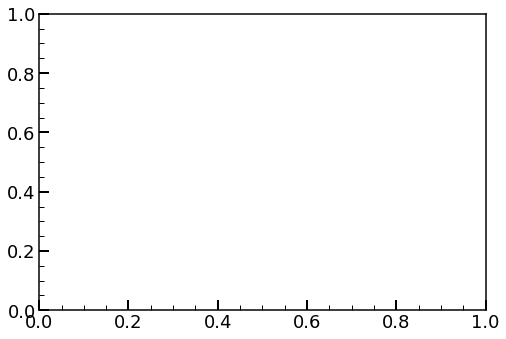

In [122]:
fig = plt.figure(figsize=(8, 12))
ax = plt.subplot(212)

J = 2
k = 1

if k == 9 or k == 10 or k == 11: 
    i  = 0
    
elif k == 0 or k == 1 :
    i = 1

best, bbest,nbest = banana_plot_single(J=J, k=k, ax=ax, xlim=[14.0, 15.2], ylim=[10,55])
ax.set_yticks(range(15,65, 10))

# k = 0 - Fe, k = 9 - S

ax2 = plt.subplot(211)
sightline = metalz['sightline'][J]

a = np.where(t['sightline'] == sightline)
sigT = t[a]
print(lines[k][1])
b = np.where(sigT['line'] == lines[k][1])
finT = sigT[b]

W = cog.CoG_full(nbest,bbest,LF_m)

wav, w0, w0_err = finT['linewav'].value, finT['Wr'].value ,finT['Wr_err'].value
print(wav,w0,w0_err)

# translate uncertanieties

eqw = unumpy.uarray(w0,w0_err)
y = unumpy.log10(eqw / 1000. / wav)
x = lf[i] - 8  # move to cm

# plot the guess
plt.errorbar(x,unumpy.nominal_values(y), yerr=unumpy.std_devs(y), fmt='ro')
plt.plot(LF_m,np.log10(W), c = 'blue', lw=3)
plt.ylim([-5.0, -3.0])
plt.xlabel(r"log$_{10}$(f$\lambda$)", fontsize=22)
plt.ylabel(r"log$_{10}(W_{\lambda} / \lambda$)", fontsize=22)
plt.annotate(best, (0.5,0.85), xycoords='axes fraction')
plt.annotate(f"{sightline} \n{lines[k][1]}", (0.05, 0.85), xycoords='axes fraction')
plt.tight_layout()
fig.savefig(sightline + " "+lines[k][1]+"_CoG_cont_fit.png", bbox_inches='tight')


# Proposal plots

NameError: name 'ic1613' is not defined

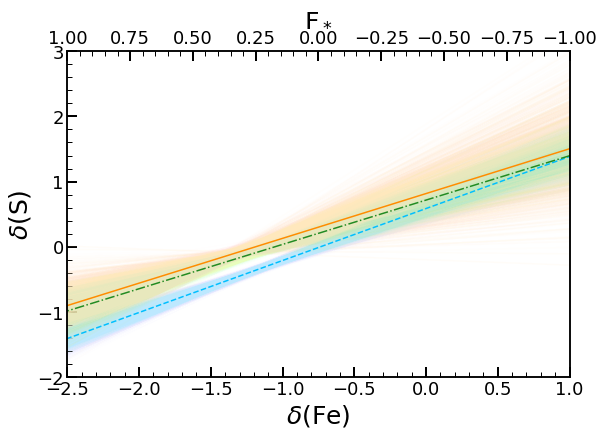

In [123]:
# Proposal
# Relation between d(Fe) and d(S) - HST prposal for Sextans A

fig=plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax2.set_xlim([1,-1.])
ax2.set_xlabel(r'F$_*$')
ax1.set_xlabel(r'$\delta$(Fe)')
ax1.set_ylabel(r'$\delta$(S)', fontsize=25)
ax1.set_ylim([-2.,3.0])
ax1.set_xlim([-2.5,1.])

dFe = np.linspace(-3,3, 100) #

## METAL depletion relations
#MW - 0 
k = 0
mw_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
mw_dS = dep.delta(mw_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
mw_t,mw_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)
# LMC
k = 1
lmc_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
lmc_dS = dep.delta(lmc_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
lmc_t,lmc_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)

# SMC
k = 2
smc_Fs = dep.F_star(dFe, Mco['AFe'][k], Mco['BFe'][k], Mco['zFe'][k])
smc_dS = dep.delta(smc_Fs, Mco['AS'][k], Mco['BS'][k], Mco['zs'][k]) #depletions S
smc_t,smc_p = dep.mc_dep_fit_rel_errors(dFe,Mco['AFe'][k], Mco['AFe_e'][k], Mco['BFe'][k], Mco['BFe_e'][k], 
            Mco['zFe'][k], Mco['AS'][k], Mco['AS_e'][k], Mco['BS'][k], Mco['BS_e'][k], Mco['zs'][k], nmc = 1000)

# propagate METAL relation errors
for i in range(1000):
    ax1.plot(dFe,mw_t.T[i], '-',c='#ffe8bd', alpha=np.sqrt(mw_p[i])/10.)
    ax1.plot(dFe,lmc_t.T[i], '-',c='#bde8ff', alpha=np.sqrt(lmc_p[i])/20.)
    ax1.plot(dFe,smc_t.T[i], '-',c='#e8ffbd', alpha=np.sqrt(smc_p[i])/30.)

# ## plot the METAL relations
ax1.plot(dFe, mw_dS, c=Cmw, ls='-' , label='MW')
ax1.plot(dFe, lmc_dS, c=Clmc, ls='--' , label='LMC')
ax1.plot(dFe, smc_dS, c=Csmc, ls='dashdot' , label='SMC')

# ## plot METAL-Z measurements

ax1.errorbar(ic1613['d(Fe)'][:,0],ic1613['d(S)'][:,0], fmt='o', markeredgewidth=1,label='IC1613', 
             markersize=15,markeredgecolor='k',markerfacecolor='k', 
             xerr=[ic1613['d(Fe)'][:,1],ic1613['d(Fe)'][:,2]], yerr=[ic1613['d(S)'][:,1],ic1613['d(S)'][:,2]], 
             ecolor='k', elinewidth=1, zorder=2000, alpha=0.5)
ax1.errorbar(sexA['d(Fe)'][:,0],sexA['d(S)'][:,0], fmt='o', markeredgewidth=1,label='Sextans-A', markersize=15,markeredgecolor='r',markerfacecolor='r', 
             xerr=[sexA['d(Fe)'][:,1],sexA['d(Fe)'][:,2]], yerr=[sexA['d(S)'][:,1],sexA['d(S)'][:,2]], ecolor='r',elinewidth=1, zorder=3000)

ax1.legend(loc=4, ncol=2)

fig.savefig("dep-S-Fe-prop.png", facecolor='white', bbox_inches='tight')



In [ ]:
###### METAL-Z estentio HSt proposal expected NH
exp_dfe = np.array([-0.62028617, -0.98303002, -0.94319198, -0.63204841, -0.85921792,
       -0.50187953, -0.63838992, -0.51979681, -0.59920493, -1.00586103,
       -0.46771412, -0.76616521, -0.64981337, -0.86865397, -0.66686477,
       -0.74111059, -1.02699185, -0.75324633, -0.70585968, -0.68665817,
       -0.67087366, -1.01037408])

exp_nh = np.array([20.92924813, 21.44015496, 21.38404504, 20.94581467, 21.26577172,
       20.76247822, 20.95474636, 20.78771381, 20.89955624, 21.4723113 ,
       20.71435792, 21.13471157, 20.97083573, 21.27906193, 20.99485179,
       21.09942337, 21.50207303, 21.11651596, 21.04977419, 21.02272981,
       21.00049811, 21.47866772])

In [ ]:
# get dep(Fe) - logNH relations for METAL-Z
NH = np.linspace(18,23, 100)

new_cut2 = np.array([20.59, 20.81,21.05,21.22, 21.26, 21.27])

fig = plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.xlabel('log N(H)', fontsize=25)
plt.ylabel(r'$\delta$(Fe)', fontsize=25)
plt.xlim([19.5,22.5])
plt.ylim([-3., 1.5])

# METAL measurements
plt.plot(mw_NH, mw_Fe, '^', label='MW', markersize=18, c=Cmw,alpha=0.15)
plt.plot(lmc_NH, lmc_Fe, 'p', label='LMC', markersize=18, c=Clmc,alpha=0.2)
plt.plot(smc_NH, smc_Fe, 's', label='SMC', markersize=18, c=Csmc,alpha=0.25)

# METAL-Z measurements
plt.errorbar(ic1613['N(HI)'][:,0],ic1613['d(Fe)'][:,0], fmt='o', markeredgewidth=1,label='IC1613', 
             markersize=15,markeredgecolor='k',markerfacecolor='k', 
             xerr=ic1613['N(HI)'][:,1], yerr=[ic1613['d(Fe)'][:,1],ic1613['d(Fe)'][:,2]], ecolor='k', 
             elinewidth=1, alpha=0.3)
plt.errorbar(sexA['N(HI)'][:,0],sexA['d(Fe)'][:,0], fmt='o', markeredgewidth=1,label='Sextans-A', markersize=15,markeredgecolor='r',markerfacecolor='r', 
              xerr=sexA['N(HI)'][:,1], yerr=[sexA['d(Fe)'][:,1],sexA['d(Fe)'][:,2]], ecolor=Csex, elinewidth=1, alpha=0.8)

# Sextans A Fe

Fe_sa = np.array([-0.71, -0.87])
aa = np.linspace(-0.65, -0.77, 10)
bb = np.linspace(-0.61, -1.16, 10)  

Y = (NH - zlmc_Fe) * Fe_sa[0] + Fe_sa[1]

# If d(X) > 0, change to 0 (non physical)

# for i in range(10):
#     for j in range(10):
        
#         y = (NH - zlmc_Fe) * aa[i] + bb[j]
#         plt.plot(NH,np.where(y < 0, y,0), '-', c='lightpink', alpha=0.3)
# plt.plot(NH, np.where(Y < 0, Y, 0), c='r', ls='--' ,label='Sextans A fit')


plt.fill_betweenx([-3,1.5], 20.4,20.6, color='navy', alpha=0.2)
plt.fill_betweenx([-3,1.5], 21.2,21.4, color='navy', alpha=0.2)
plt.fill_betweenx([-3,1.5], 20.8,21.1, color='navy', alpha=0.2)
plt.legend(fontsize=12)
plt.annotate("Z", xy=(22.3, -2), xytext=(22.25, -0.5),arrowprops=dict(arrowstyle="->",               
                                                                      linewidth=3, color='navy'), fontsize=22)

plt.subplot(122)

bins=np.linspace(20.3, 21.5,15)
new_cut2 = np.array([20.38, 20.59, 20.81,21.05,21.22, 21.26, 21.27])
sexa_metal = np.array([20.46, 20.71, 21.17, 21.11, 20.90, 21.11, 21.07, 20.38 ])

plt.hist(np.append(new_cut2, sexa_metal), label='This proposal + METAL-Z', color='navy' , alpha=0.5, lw=2, bins=bins)
plt.hist(sexa_metal, histtype='step', lw=3, label='METAL-Z', color='orange', hatch='//', bins=bins)


#plt.title("SEXTANS-A", fontsize=20)
plt.xlabel("log N(H)", fontsize=20)
plt.legend(loc=2, fontsize=15)
plt.ylim([0,2.5])


fig.savefig("nh-proposal.png", facecolor='white',  bbox_inches='tight')


In [ ]:
# ds9 file
for i in range(np.size(ic1613['sightline'])):
    print(f"""fk5;circle({ic1613['RA [deg]'][i]},{ic1613['Dec [deg]'][i]},1.25")""")

In [ ]:
dX_NH = dep.dep_nh(NH, b=-1.20, a = -0.54)
dX_NH2 = dep.dep_nh(NH, b = -0.79, a = -0.47)

dmw = -0.41 * (NH - 21.097) -1.62
dlmc = -0.71 * (NH - 21.288) - 1.39
dsmc = -0.59 * (NH - 21.469) - 1.18

plt.figure(figsize=(16,6))

dFe = -0.41 * (NH - 21.097) -1.62
afe,bfe,zfe = -1.28, -1.51, 0.437
Fs = dep.Fstar(dFe, afe, bfe, zfe )

dsi = -1.14 * (Fs - 0.305) - 0.57
dmg = -1 * (Fs - 0.531) -0.80

plt.subplot(121)
plt.plot(NH, np.where(dsi<0, dsi, 0), label='Si')
plt.plot(NH, np.where(dmg<0, dmg, 0), label='Mg' )
plt.xlabel("log N(H)")
plt.ylabel("d(Fe) analytical")
plt.legend()
plt.subplot(122)
dhsi = -0.47 * (NH - 20.682) - 0.81
dhmg = -0.26 * (NH - 21.121) - 0.83
plt.plot(NH, np.where(dhsi < 0, dhsi, 0))
plt.plot(NH, np.where(dhmg < 0, dhmg, 0))
plt.xlabel("log N(H)")
plt.ylabel("d(Fe) fitted")


In [ ]:
def feldmann_versions(tier = 1, log_nh0_mw = 21., use_fe_dla=False, use_gal_dla = 'dla'):

    ### read D/G for METAL galaxies
    dg_metal = Table.read("metal-dg.txt", format='csv')

    ##HERE total_dust_mass; total_dust_mass_error; total_gas_mass; total_gas_mass_error;

    zs = np.array([1., 0.5, 0.2, 0.15, 0.08])
    gals = np.array(['MW', 'LMC', 'SMC', 'IC1613', 'Sextans-A'])
    c1, c2 ='#fde725', '#440154'
    
    gal_cols = [c1,c1,c1, Cic, Csex]

    z0min, gamma0min, dog0min, dm0min, dp0min, alpha0min = feldmann2015_model(gamma = [2e4] )
    z0min = z0min/0.014
    z0max, gamma0max, dog0max, dm0max, dp0max, alpha0max = feldmann2015_model(gamma = [4e4] )
    z0max = z0max/0.014

    zmin, gammamin, dogmin, dmmin, dpmin, alphamin = feldmann2015_model(gamma = [2e3] )
    zmin = zmin/0.014

    zmax, gammamax, dogmax, dmmax, dpmax, alphamax = feldmann2015_model(gamma = [1e6] )
    zmax = zmax/0.014

    z0, gamma0, dog0, dm0, dp0, alpha0 = feldmann2015_model(gamma = [3e4] )
    z0 = z0/0.014

    dla = ascii.read('decia2016_table6.dat')
    devis = ascii.read('dustpedia_combined_sample.csv')
    remy_ruyer = ascii.read('remy-ruyer2014_dust_gas_masses.dat')

    plt.clf()
    plt.close()

    fig, ax = plt.subplots(nrows = 1, ncols = 1,figsize = (9,9))
    #plt.grid()
    ax.fill_between(zmin, dogmin[:,0],dog0min[:,0], color = 'silver', alpha = 0.65)
    ax.fill_between(zmax, dog0max[:,0],dogmax[:,0], color = 'silver', alpha = 0.65)
    ax.plot(z0, dog0, '--', color='grey')

    dumz = np.arange(5e-3, 3, 0.001)
    ind = np.where(z0 == 1)
    ind = ind[0]
    dumdg = dog0.flatten()[ind]*dumz

    ax.plot(dumz, dumdg, '-', linewidth=3, color='grey')
    ax.text(6e-3, 8.e-5, 'D/G '  +u"\u221D" + ' Z', color = 'black', fontsize = 15, rotation = 18)
    ax.text(0.2, 8e-6, 'Model Tracks', fontsize = 13, color = 'gray')
    ax.text(0.2, 5e-6, '(Feldmann+2015)', fontsize = 13, color = 'gray')

    
    ax.set_xlim(left = 5.e-3,right=3.)
    ax.set_ylim(bottom = 3.e-7, top = 0.5)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel("Z [" + r'$Z_o$' + "]", fontsize = 22)
    ax.set_ylabel('D/G', fontsize = 22)
    

#     #  DE VIS
    if tier == 1 or tier == 2 or tier == 3:
        ax.plot(devis['Z'].data, devis['Mdust'].data/devis['Mgas'].data, 'o',  markerfacecolor = '#3b528b', markeredgecolor='none', label = 'FIR (Remy-Ruyer+2014, De Vis+2019)', alpha = 0.6)
        ax.plot(10.**(remy_ruyer['12+log(O/H)'].data-8.76), remy_ruyer['Mdust'].data/remy_ruyer['Mgas'].data, 'o', markerfacecolor = '#3b528b',  markeredgecolor='none', alpha = 0.6)

    if tier == 2 or tier == 3:
        
        chris = np.array([3.5e-3, 1.5e-4])/ 1.36
        plt.plot([zs[1]- 0.05, zs[2]-0.01], chris, '*', ms=25, markerfacecolor=Clmc, markeredgewidth=1, markeredgecolor='k', label=r'FIR at log N(H) = 21 cm$^{-2}$ LMC/SMC  (Clark+2023)')

        for i in range(3): #METAL depletion measures

            linewidth = 4
            if gals[i] == 'LMC' or gals[i] == 'SMC' or gals[i] == 'MW':
                if gals[i] == 'MW':
                    ax.plot(zs[i],dg_metal['dg_N20'][i],'o', markerfacecolor = '#fde725', label = "MW/LMC/SMC (Roman-Duval+2022a)", markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
            else:
                ax.plot(-1,-1,'o', color = gal_cols[i], label = gals[i] + " (this work)", markersize = 17, alpha= 0.7, markeredgecolor='k')

            ax.plot(zs[i],dg_metal['dg_N20'][i],'o', color = gal_cols[i], markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
            ax.plot(zs[i],dg_metal['dg_N21'][i],'s', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k', markeredgewidth=2)
            ax.plot(zs[i],dg_metal['dg_N22'][i],'^', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k', markeredgewidth=2)

        o, = ax.plot(-1,1,'o', color = gal_cols[i], markersize = 17, alpha= 0.8, markeredgecolor='k', markerfacecolor='none',  markeredgewidth=2)
        s, = ax.plot(-1,1,'s', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k',  markerfacecolor='none', markeredgewidth=2)
        d, = ax.plot(-1,1,'^', color = gal_cols[i], markersize = 17, alpha= 0.8,markeredgecolor='k',  markerfacecolor='none', markeredgewidth=2)

        ncol=[] 
        ncol.append([o,s,d])
        leg1 = ax.legend(ncol[0], ['log N(H) = 20 cm$^{-2}$','log N(H) = 21 cm$^{-2}$','log N(H) = 22 cm$^{-2}$'], fontsize=12, loc=4)
        leg1.legendHandles[0].set_color('k')
        
    if tier == 3 :
#     #  DLAs - need to scale to log_nh0_mw

        if use_fe_dla==True:
            key='_Fe'
        else:
            key=''
        tfit = ascii.read("LMC_fit_DG_NH.dat")
        fslope = tfit['slope'].data[0]
        foffset= tfit['offset'].data[0]
        err_fslope = tfit['err_slope'].data[0]
        err_foffset= tfit['err_offset'].data[0]
        dla = fits.open("DeCia2016_all_data_"+use_gal_dla + key + ".fits")
        dla = dla[1].data

        scaled_dg  = dla['DTG'] + fslope*(log_nh0_mw-dla['LOG_NHI'])
        err_scaled_dg = np.sqrt(dla['err_DTG']**2 + (fslope*(log_nh0_mw-dla['LOG_NHI']))**2*((err_fslope/fslope)**2 + (dla['ERR_LOG_NHI']/dla['LOG_NHI'])**2))

        good_dla = np.where((dla['LOG_NHI']>=19.5) & (dla['DTG'] >0))
        ax.plot(dla['tot_A_Fe'][good_dla]/10.**(7.54-12.), dla['DTG'][good_dla], 'o', markerfacecolor = 'magenta', markeredgecolor='none', label = 'DLAs (Quiret+2016, DeCia+2016)' , alpha = 0.5)

        dla = fits.open("Quiret2016_DTG_table_"+use_gal_dla + key + ".fits")
        dla = dla[1].data
        scaled_dg  = dla['DTG'] + fslope*(log_nh0_mw-dla['LOG_NHI'])
        err_scaled_dg = np.sqrt(dla['err_DTG']**2 + (fslope*(log_nh0_mw-dla['LOG_NHI']))**2*((err_fslope/fslope)**2 + (dla['ERR_LOG_NHI']/dla['LOG_NHI'])**2))
        good_dla = np.where((dla['LOG_NHI']>=19.5) & (dla['DTG'] >0))
        ax.plot(dla['tot_A_Fe'][good_dla]/10.**(7.54-12.), dla['DTG'][good_dla], 'o',  markerfacecolor = 'magenta' , markeredgecolor='none', alpha = 0.5)

    
    for i in [3,4]: #METAL depletion measures

        linewidth = 4
        if gals[i] == 'LMC' or gals[i] == 'SMC' or gals[i] == 'MW':
            if gals[i] == 'MW':
                ax.plot(zs[i],dg_metal['dg_N20'][i],'o', markerfacecolor = '#fde725', label = "MW/LMC/SMC (Roman-Duval+2022a)", markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
        else:
            ax.plot(-1,-1,'o', color = gal_cols[3], label = gals[i] + " (this work)", markersize = 17, alpha= 0.7, markeredgecolor='k')

        ax.plot(zs[i],dg_metal['dg_N20'][i],'o', color = gal_cols[4], markersize = 17, alpha= 0.8, markeredgecolor='k', markeredgewidth=2)
        ax.plot(zs[i],dg_metal['dg_N21'][i],'s', color = gal_cols[4], markersize = 17, alpha= 0.8,markeredgecolor='k', markeredgewidth=2)
        ax.plot(zs[i],dg_metal['dg_N22'][i],'^', color = gal_cols[4], markersize = 17, alpha= 0.8,markeredgecolor='k', markeredgewidth=2)


    #ax.errorbar(1.5,dg_metal['dg_N21'][3], yerr=5e-4, fmt='x', ecolor='gray', color = 'gray', markersize = 17, alpha= 0.7)
    #ax.annotate("Typical\nerrorbar", (1.2, 3e-5), fontsize=12, c='gray')
    # Add the legend manually to the current Axes.
    #ax.legend(fontsize = 12, loc = 'upper left')
    #first_legend = plt.legend(handles=[o,s,d], loc='upper right', ncol=2)
    #plt.gca().add_artist(leg1)

    fig.savefig("feldman.pdf", dpi=1000, bbox_inches='tight', facecolor='white')


In [ ]:
## si D(Si)/G

si_mw_ab = solar_ab['MW_A'][4]-12
si_mw_dep = dep.dep_logNH(NH,mw_si[0], mw_si[2], mw_si[4] )
si_mw = 1/1.36 * (1-10**si_mw_dep)* depT['Wx'][I] * 10**(si_mw_ab)

si_lmc_ab = solar_ab['LMC_A'][4]-12
si_lmc_dep = dep.dep_logNH(NH,lmc_si[0], lmc_si[2], lmc_si[4] )
si_lmc = 1/1.36 * (1-10**si_lmc_dep)* depT['Wx'][I] * 10**(si_lmc_ab)

si_smc_ab = solar_ab['SMC_A'][4]-12
si_smc_dep = dep.dep_logNH(NH,smc_si[0], smc_si[2], smc_si[4] )
si_smc = 1/1.36 * (1-10**si_smc_dep)* depT['Wx'][I] * 10**(si_smc_ab)


plt.plot(NH, np.log10(si_mw), c=Cmw, label='MW')
plt.plot(NH, np.log10(si_lmc), c=Clmc, label='LMC')
plt.plot(NH, np.log10(si_smc), c=Csmc, label='SMC')

#METAL-Z

si_ic = 1/1.36 * (1-10**dX_NH_ic_si)* depT['Wx'][I] * 10**(ab_ic_Si)
si_sa = 1/1.36 * (1-10**dX_NH_sa_si)* depT['Wx'][I] * 10**(ab_sa_Si)

plt.plot(NH, np.log10(si_ic), c='k', ls='--', label='IC1613')
plt.plot(NH, np.log10(si_sa), c='r', ls='--', label='Sextans A')

plt.xlabel("log N(H)")
plt.ylabel("log D$_{Si}$/G")
plt.legend(loc=3, fontsize=15)